
# Credit Risk Analysis with Machine Learning

In [46]:
pip install dalex


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dalex

# Model-related imports
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold

# Pipeline-related imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.inspection import permutation_importance

# Additional tools
from IPython.core.display import display, HTML
from IPython.display import clear_output
from collections import Counter
from sklearn.datasets import make_classification

# Configuration for notebook aesthetics
display(HTML("<style>.container { width:90% }</style>"))

# Ensure plots are displayed inline in the Jupyter notebook
%matplotlib inline


## Import Data & EDA



In [ ]:
loan = pd.read_csv("loan_train.csv")
loan.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv       term  \
0  1077501.0  1296599.0     5000.0       5000.0           4975.0  36 months   
1  1077430.0  1314167.0     2500.0       2500.0           2500.0  60 months   
2  1076863.0  1277178.0    10000.0      10000.0          10000.0  36 months   
3  1069639.0  1304742.0     7000.0       7000.0           7000.0  60 months   
4  1072053.0  1288686.0     3000.0       3000.0           3000.0  36 months   

  int_rate  installment grade sub_grade  ... next_pymnt_d last_credit_pull_d  \
0   10.65%       162.87     B        B2  ...          NaN           Sep-2016   
1   15.27%        59.83     C        C4  ...          NaN           Sep-2016   
2   13.49%       339.31     C        C1  ...          NaN           Apr-2016   
3   15.96%       170.08     C        C5  ...          NaN           Sep-2016   
4   18.64%       109.43     E        E1  ...          NaN           Dec-2014   

  collections_12_mths_ex_med  policy_code application_type acc_now_delinq  \
0                        0.0          1.0       INDIVIDUAL            0.0   
1                        0.0          1.0       INDIVIDUAL            0.0   
2                        0.0          1.0       INDIVIDUAL            0.0   
3                        0.0          1.0       INDIVIDUAL            0.0   
4                        0.0          1.0       INDIVIDUAL            0.0   

  chargeoff_within_12_mths delinq_amnt pub_rec_bankruptcies tax_liens  
0                      0.0         0.0                  0.0       0.0  
1                      0.0         0.0                  0.0       0.0  
2                      0.0         0.0                  0.0       0.0  
3                      0.0         0.0                  0.0       0.0  
4                      0.0         0.0                  0.0       0.0  

[5 rows x 52 columns]

In [49]:
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [50]:
missing_values = loan.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

next_pymnt_d                  27425
mths_since_last_record        27208
mths_since_last_delinq        18907
desc                           9435
emp_title                      1822
pub_rec_bankruptcies            966
emp_length                      762
chargeoff_within_12_mths        104
collections_12_mths_ex_med      104
tax_liens                        79
last_pymnt_d                     67
revol_util                       67
delinq_2yrs                      23
pub_rec                          23
open_acc                         23
acc_now_delinq                   23
delinq_amnt                      23
inq_last_6mths                   23
total_acc                        23
earliest_cr_line                 23
title                            14
last_credit_pull_d                5
annual_inc                        4
out_prncp                         3
loan_amnt                         3
funded_amnt                       3
funded_amnt_inv                   3
term                        

In [51]:
# Analyzing the 'loan_status' distribution in the dataset
status_distribution = loan['loan_status'].value_counts(normalize=True)
print(status_distribution)


loan_status
current    0.849649
default    0.150351
Name: proportion, dtype: float64


In [52]:
# Defining the target variable for our analysis
target_var = 'loan_status'
print(target_var)


loan_status


In [53]:
numerical_features = loan.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = loan.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens']
Categorical Features: ['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']


In [54]:
# Identifying numerical features within the dataset
numerical_features = loan.select_dtypes(include=['int64', 'float64']).columns
print(numerical_features)


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')


In [55]:
# Exploring the 'term' feature's distribution
print( loan["term"].value_counts())


term
36 months    22160
60 months     7614
Name: count, dtype: int64


In [56]:
# Ensuring 'int_rate' is treated as a string and cleaning and transforming it from percentage to float
loan["int_rate"] = loan["int_rate"].astype(str).str.rstrip("%").astype(float)
print(loan["int_rate"].head())


0    10.65
1    15.27
2    13.49
3    15.96
4    18.64
Name: int_rate, dtype: float64


In [57]:
numerical_features = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', "int_rate",
    'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
    'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
    'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
    'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee',
    'last_pymnt_amnt'
]
print(numerical_features)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'last_pymnt_amnt']


In [58]:
categorical_features = loan.select_dtypes(include=['object']).columns
print(categorical_features)

categorical_features = ["term", 'grade', 'sub_grade', 'home_ownership', 'verification_status']
print("\nupdated categorical features\n", categorical_features)

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'revol_util', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype='object')

updated categorical features
 ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status']


In [59]:
# Mapping 'loan_status' to binary for our target variable
loan[target_var] = loan[target_var].map({'current': 0, 'default': 1})
print("\nUpdated Loan Status Distribution:\n", loan[target_var].value_counts())



Updated Loan Status Distribution:
 loan_status
0    25300
1     4477
Name: count, dtype: int64


### Graphs

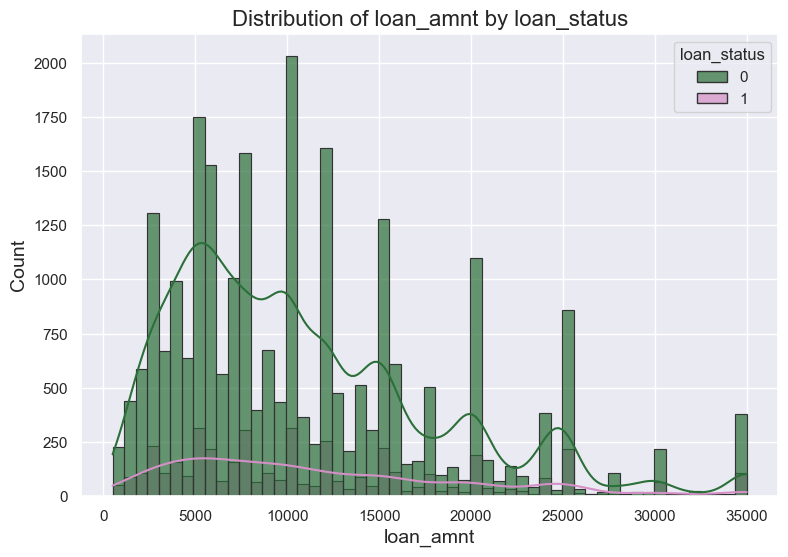

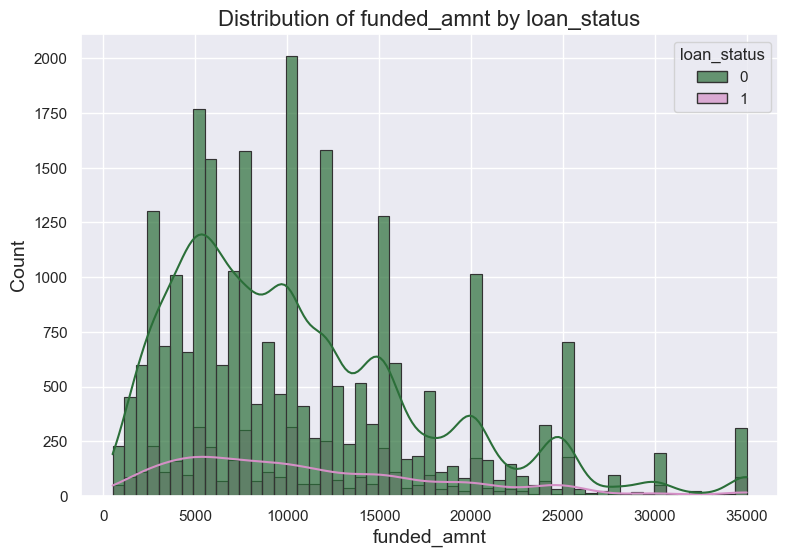

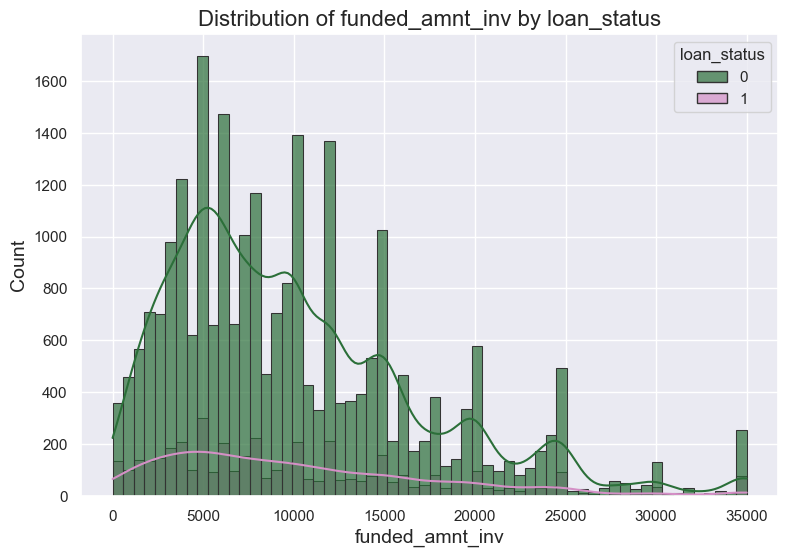

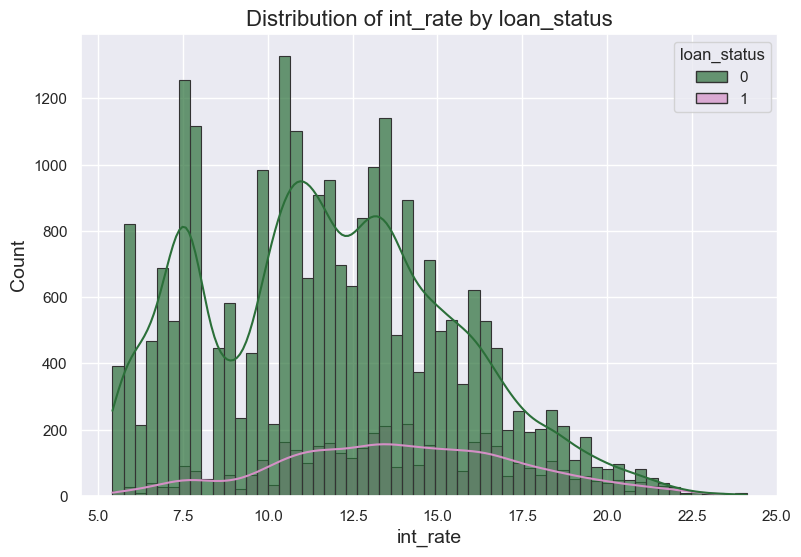

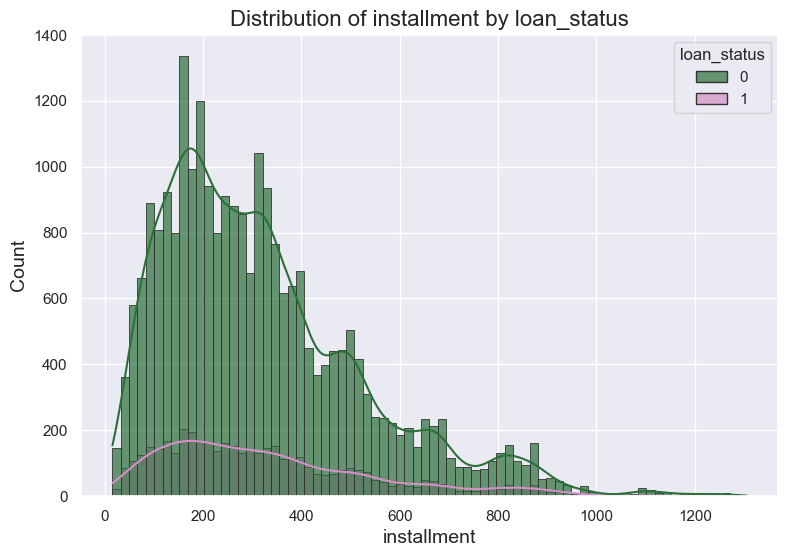

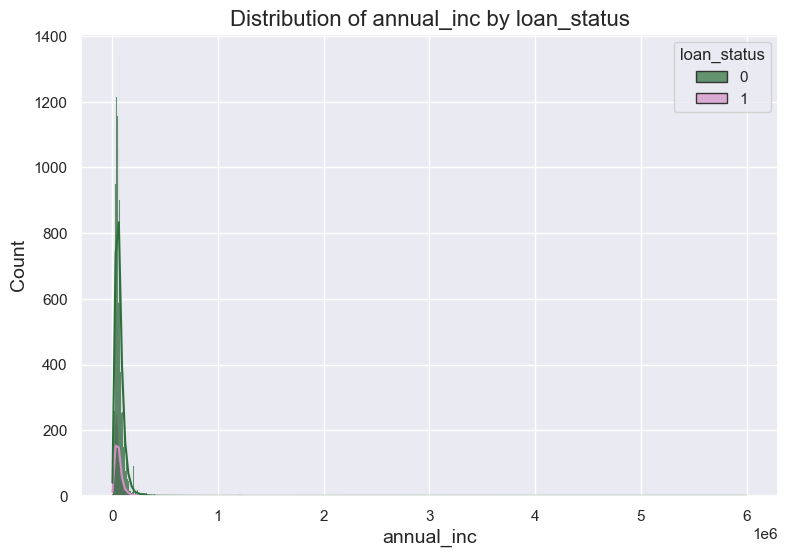

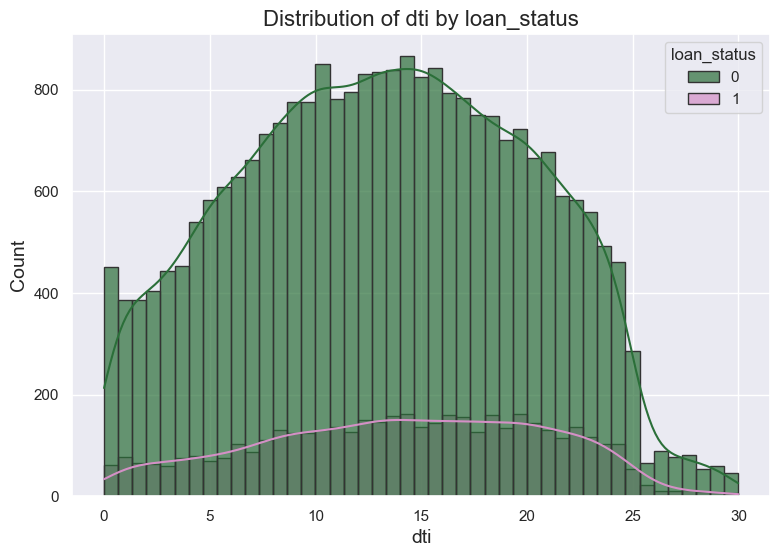

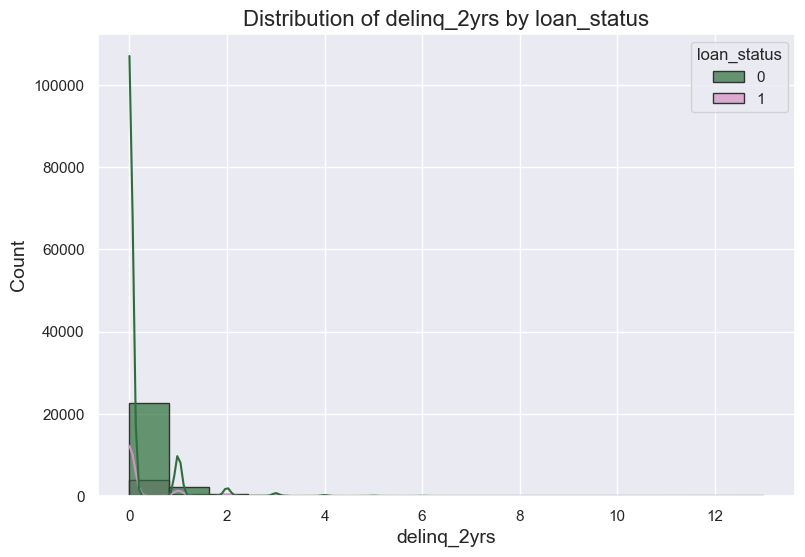

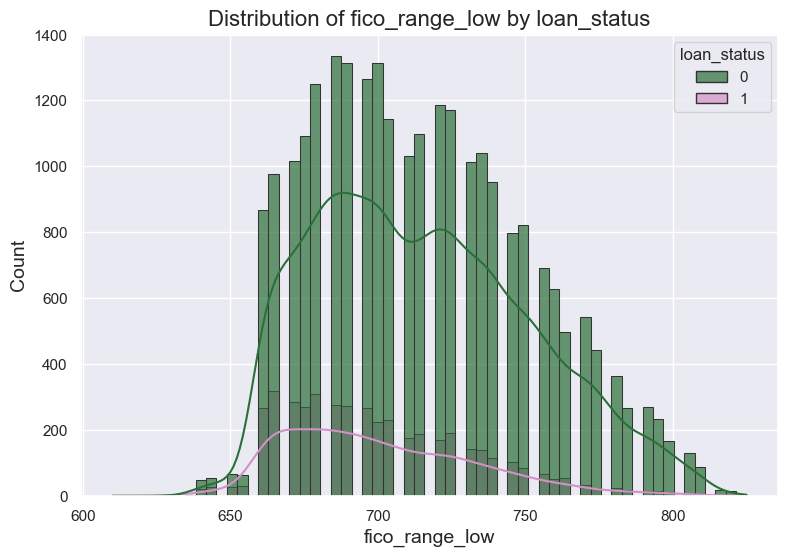

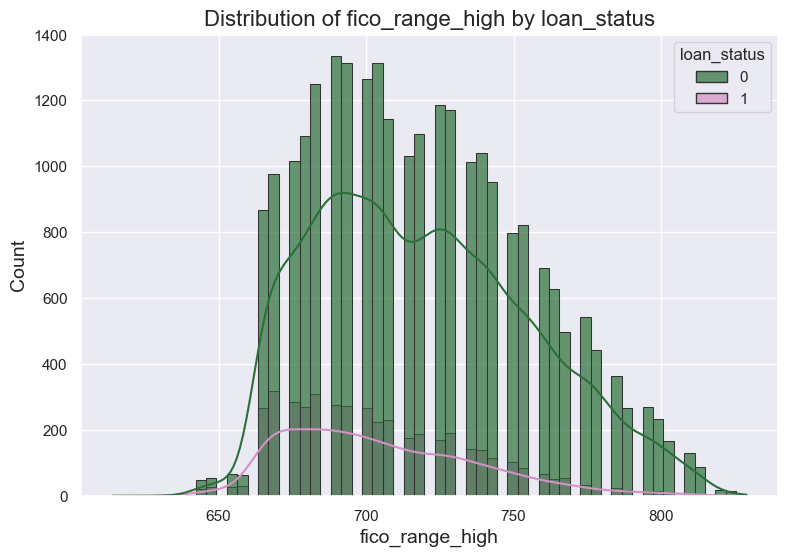

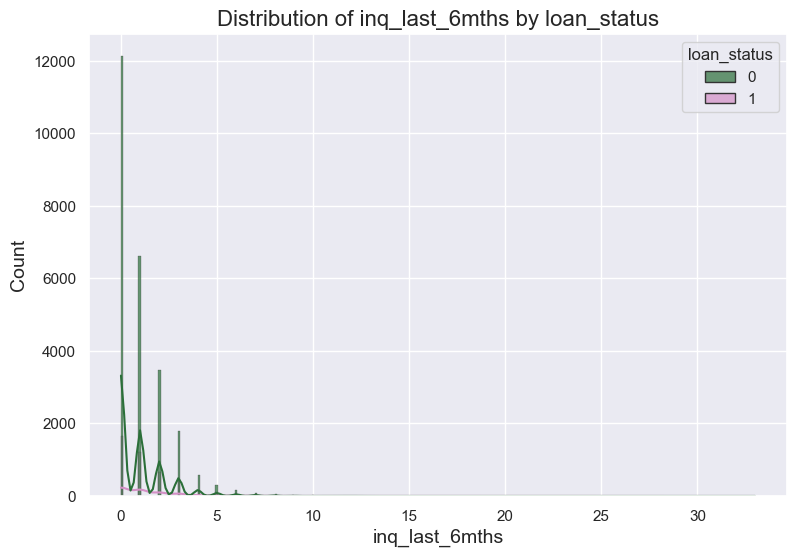

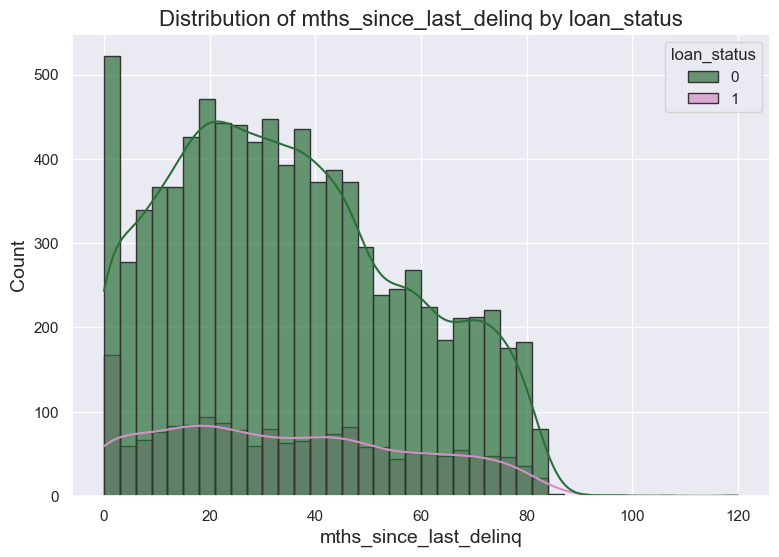

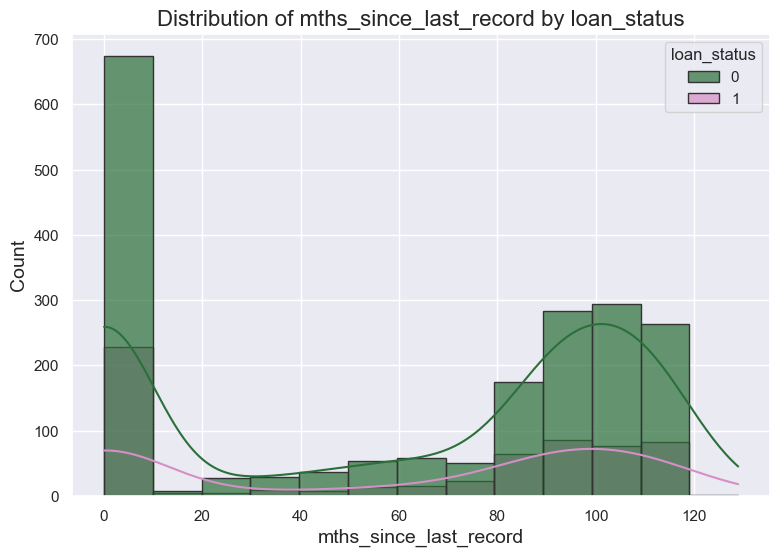

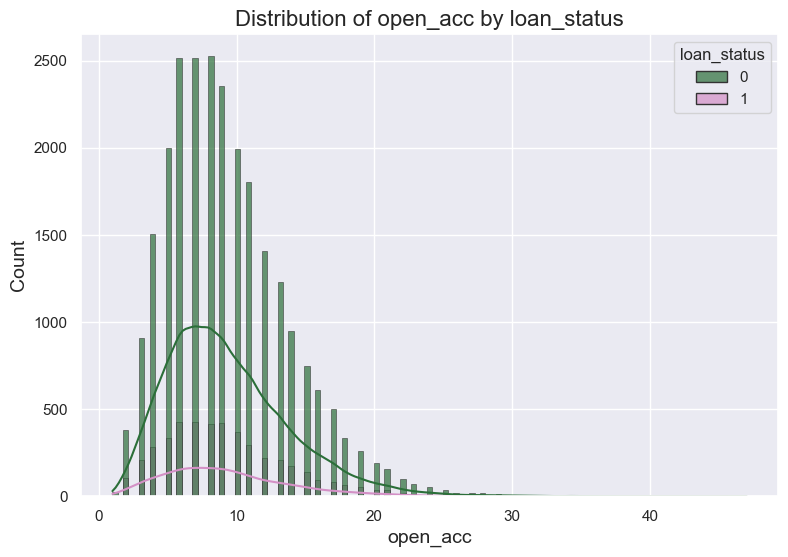

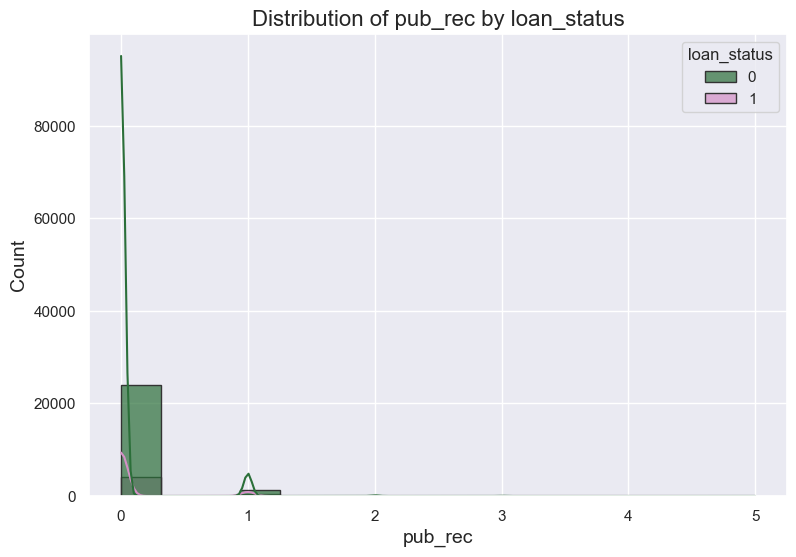

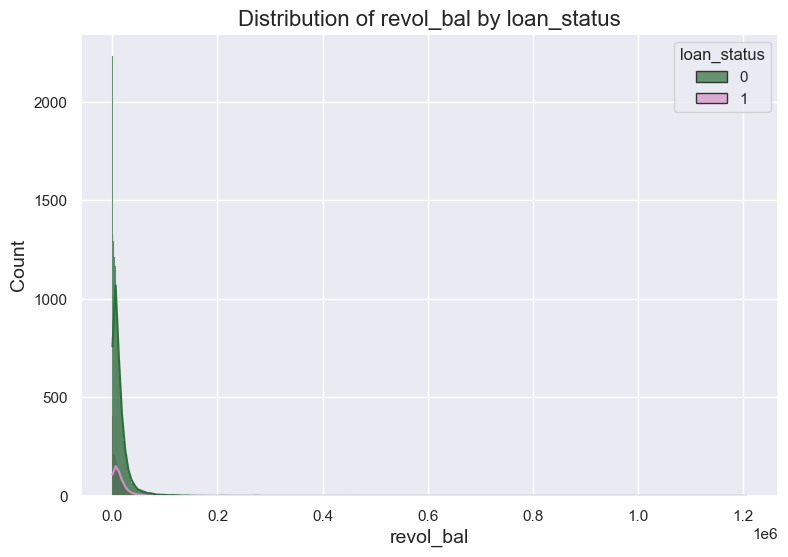

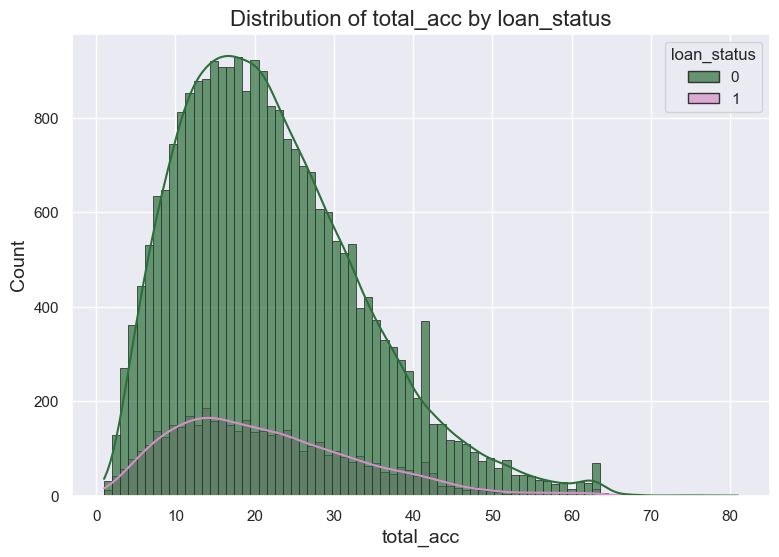

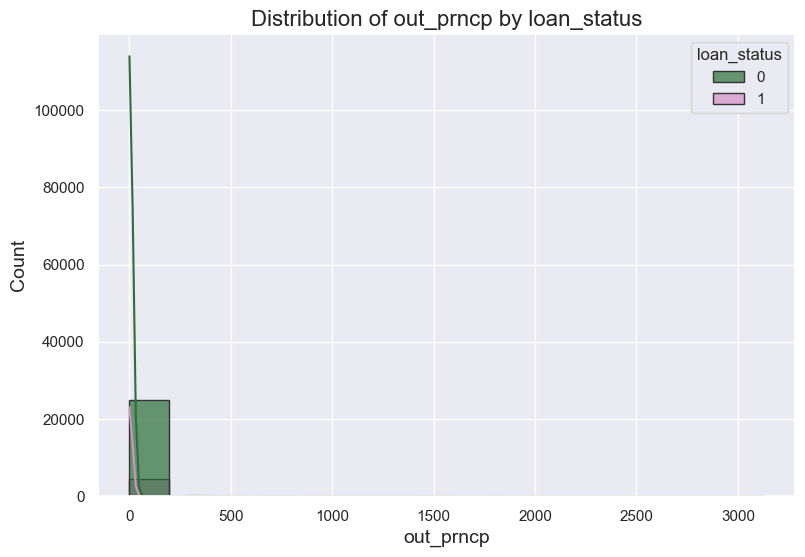

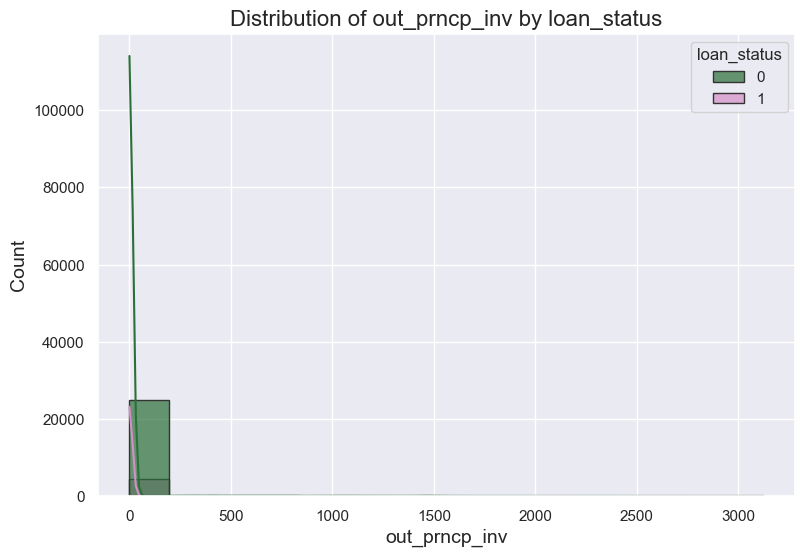

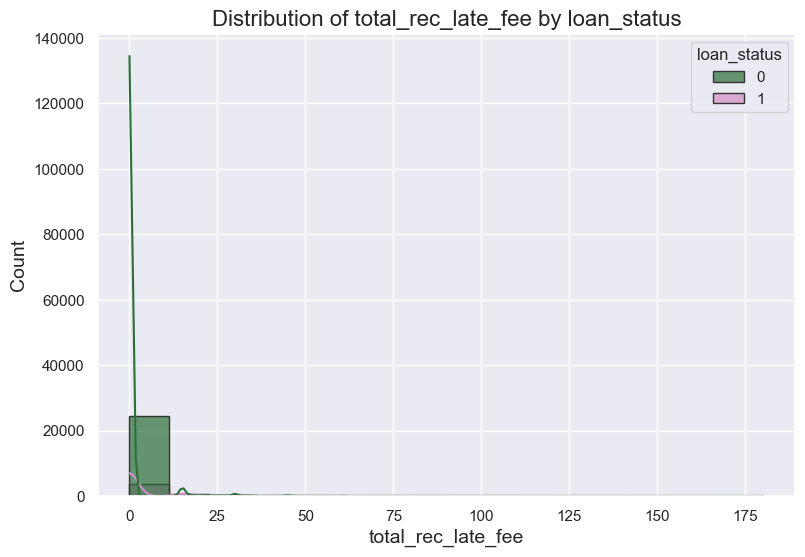

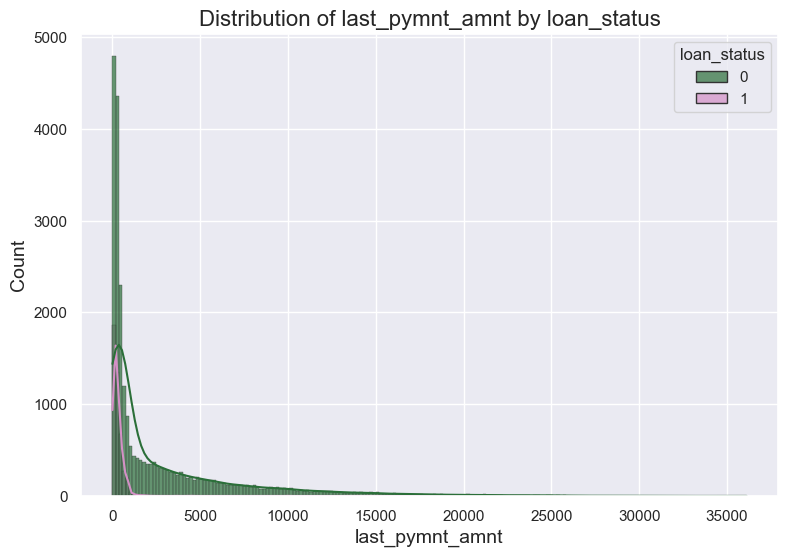

In [60]:
sns.set_theme(style="darkgrid")

for feature in numerical_features:
    plt.figure(figsize=(9, 6))
    sns.histplot(data=loan, x=feature, hue=target_var, kde=True, palette="cubehelix", alpha=0.7, edgecolor=".2")
    
    plt.title(f'Distribution of {feature} by {target_var}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.show()

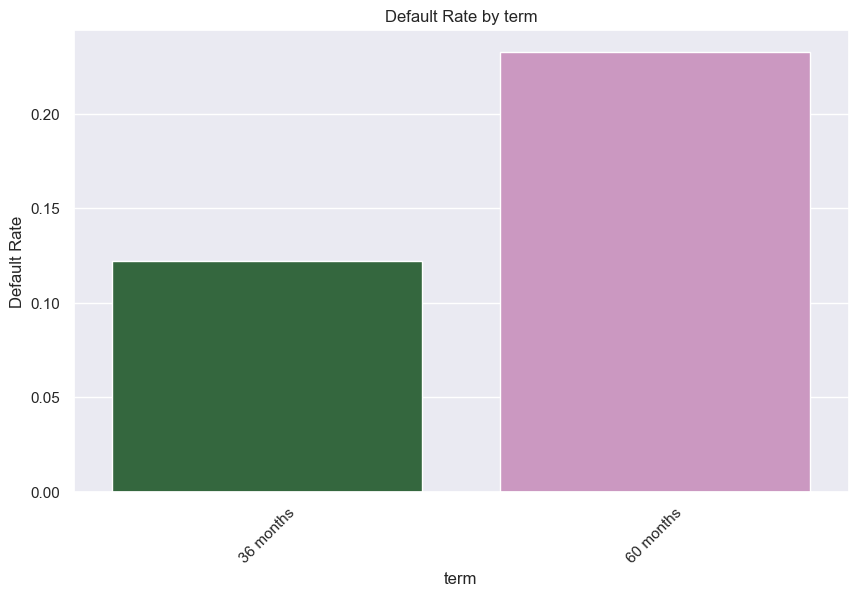

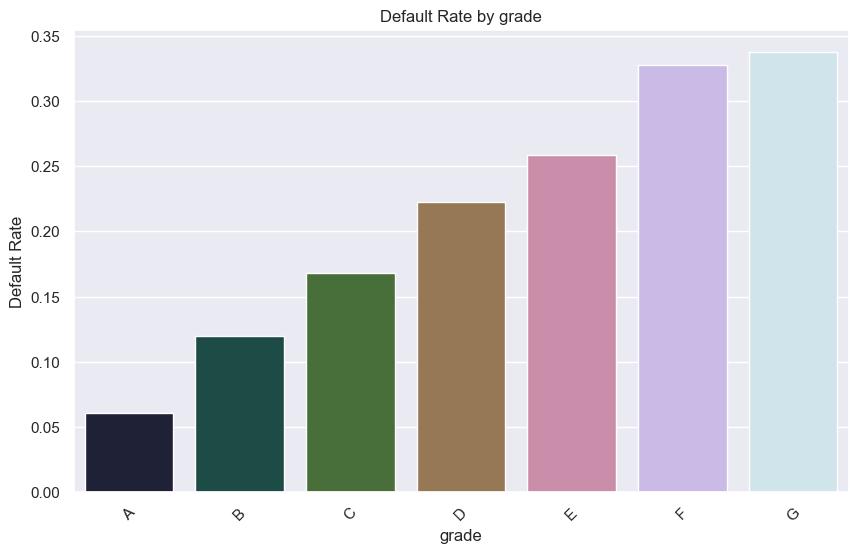

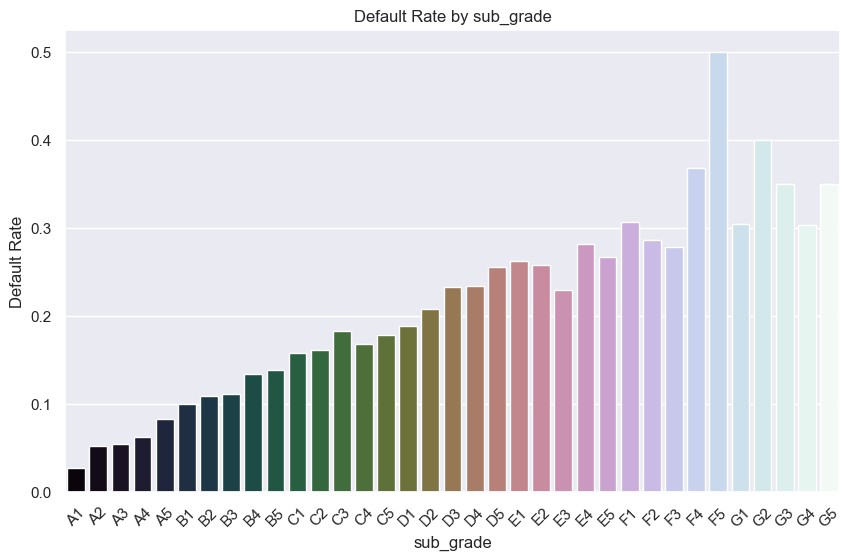

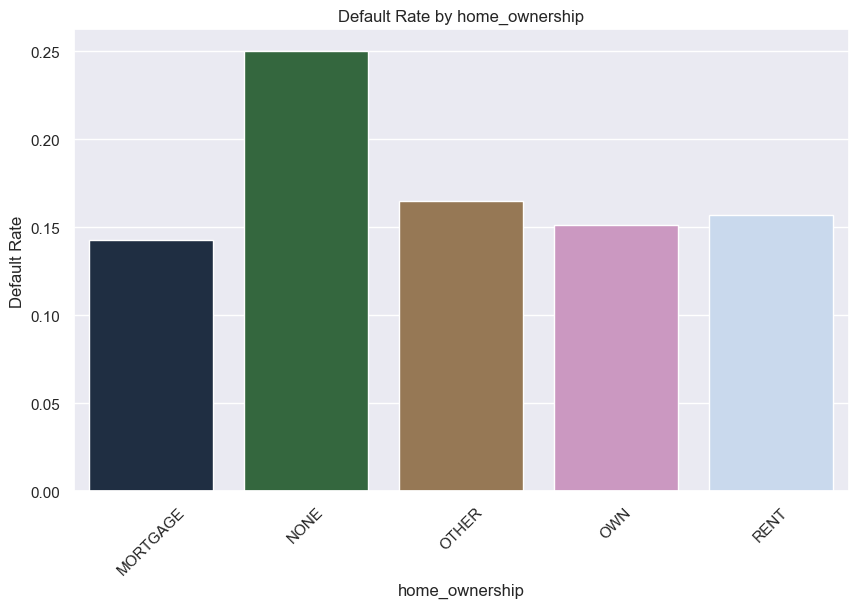

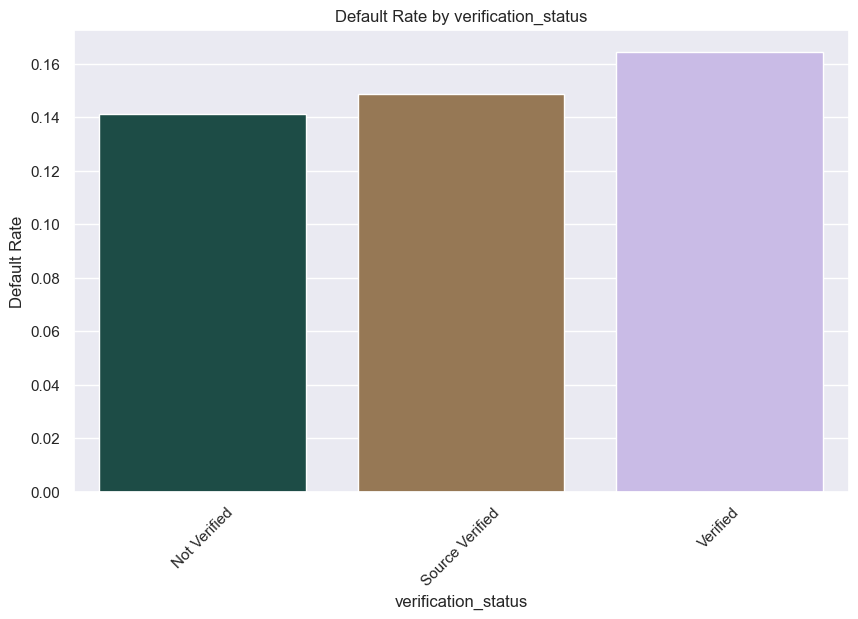

In [61]:

for cat_feature in categorical_features:
    grouped = loan.groupby(cat_feature)[target_var].value_counts().unstack().fillna(0).reset_index()
    grouped["default_rate"] = grouped[1] / (grouped[1] + grouped[0])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped, x=cat_feature, y="default_rate", palette="cubehelix")
    plt.title(f'Default Rate by {cat_feature}')
    plt.ylabel('Default Rate')
    plt.xlabel(cat_feature)
    plt.xticks(rotation=45) 
    plt.show()

For each categorical feature, we calculate the default rate and visualize it. 

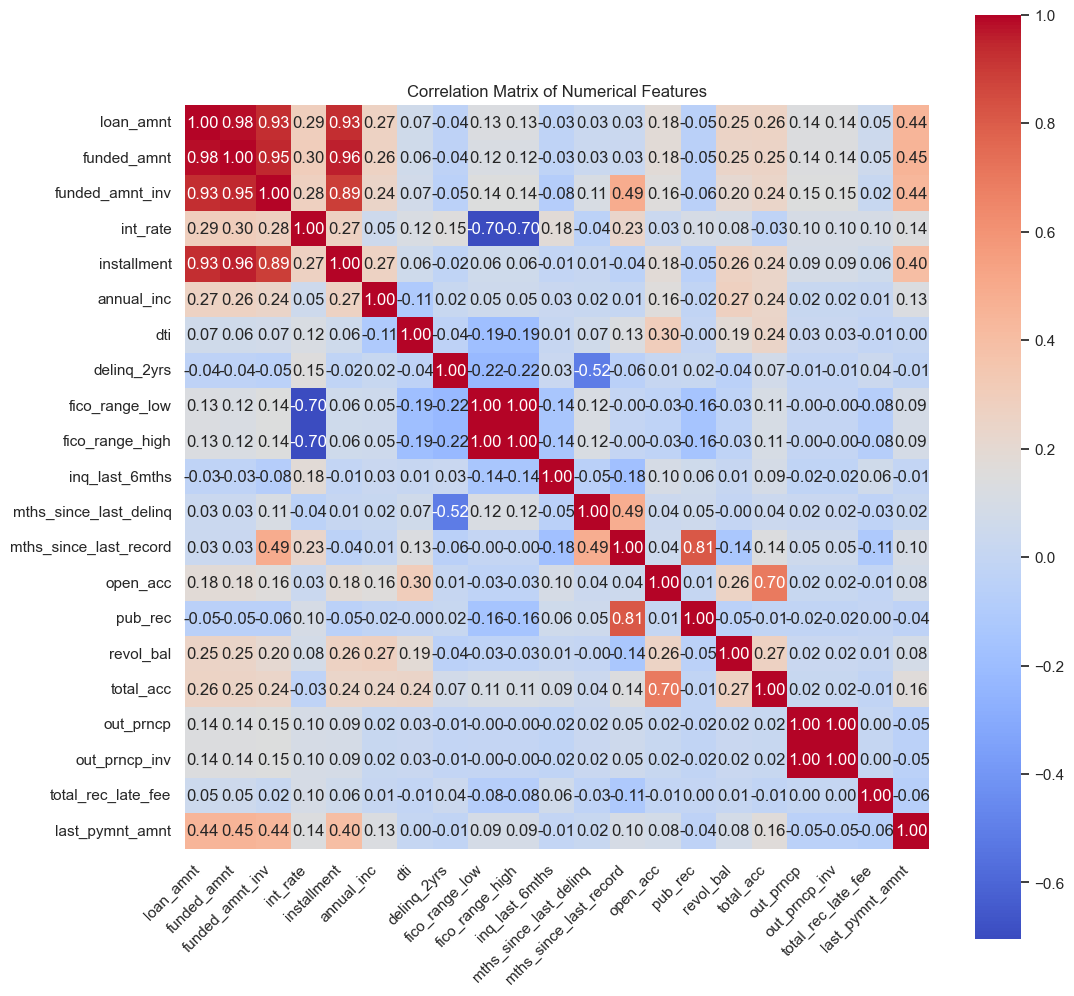

In [62]:
corr_matrix = loan[numerical_features].corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha="right") 
plt.show()

Understanding correlations among numerical features is crucial for feature selection and identifying potential multicollinearity.

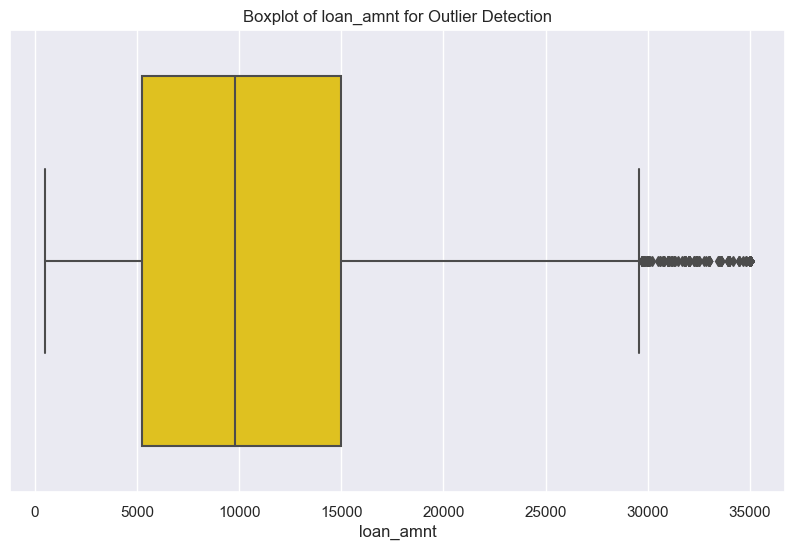

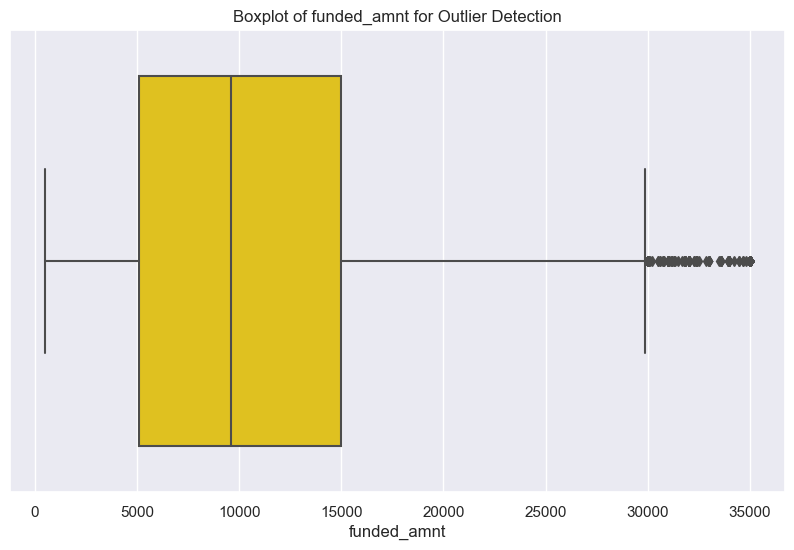

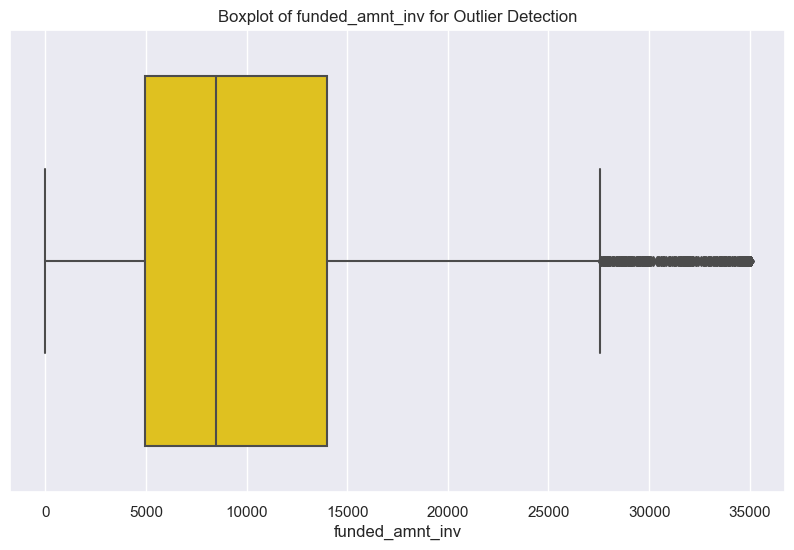

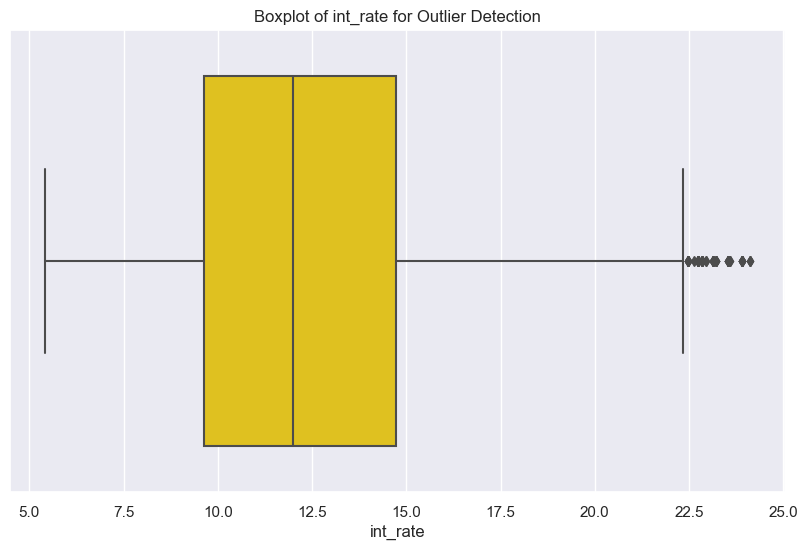

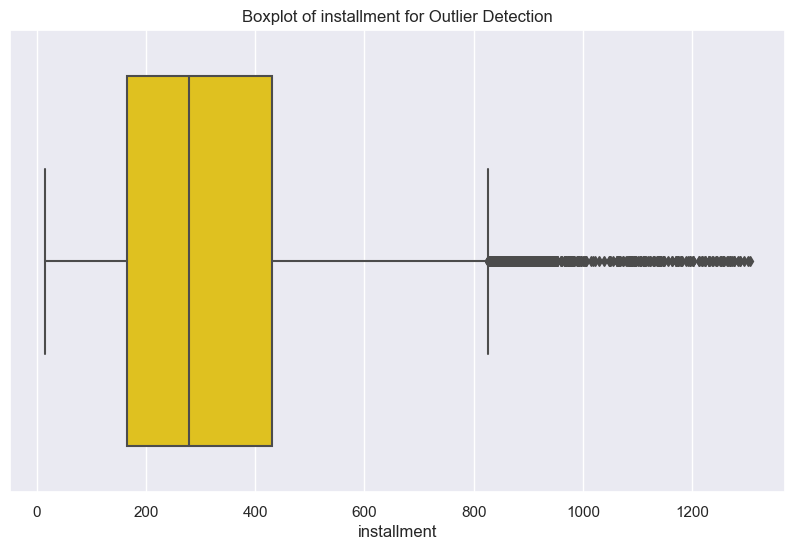

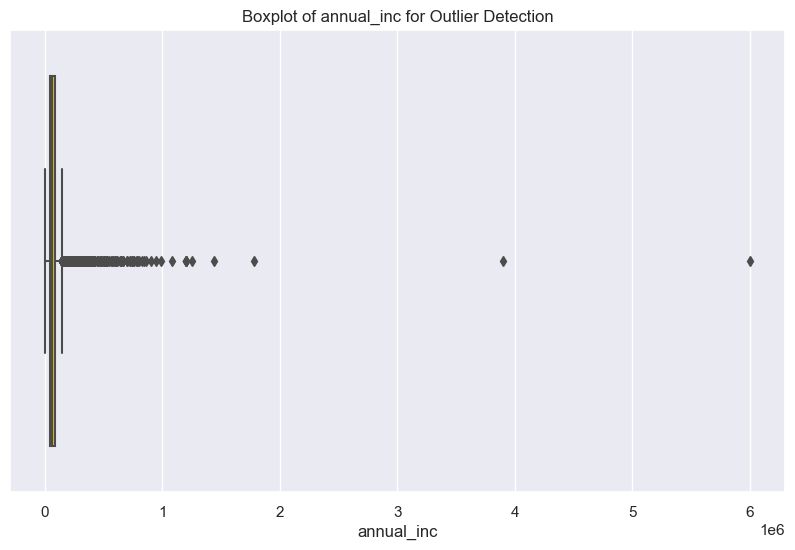

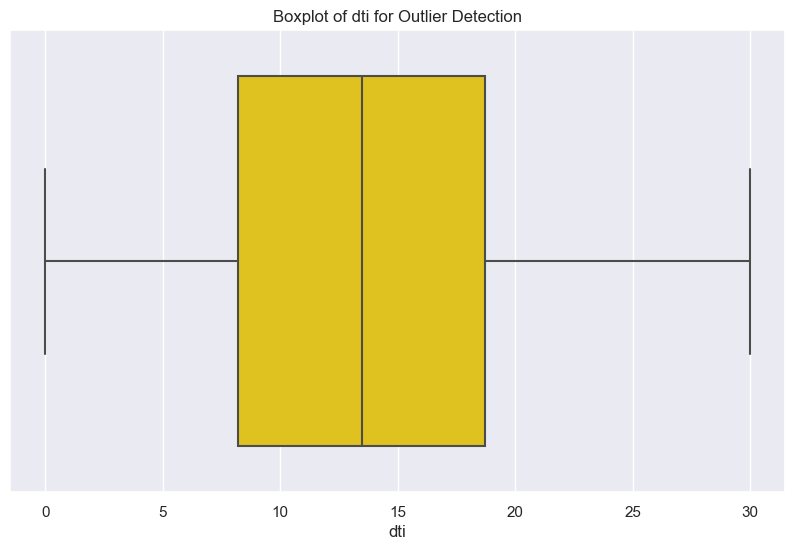

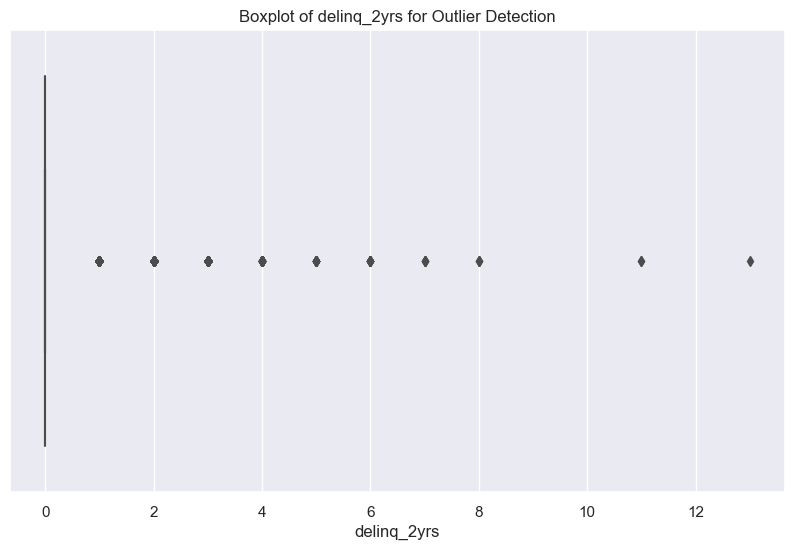

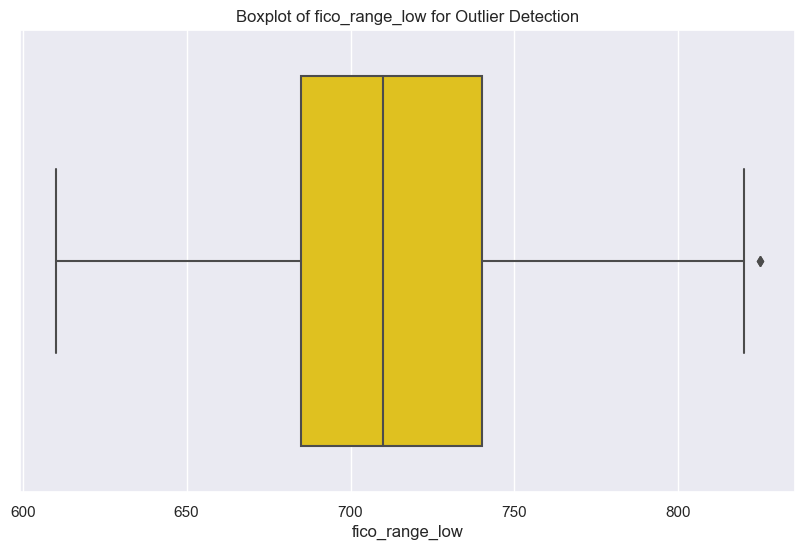

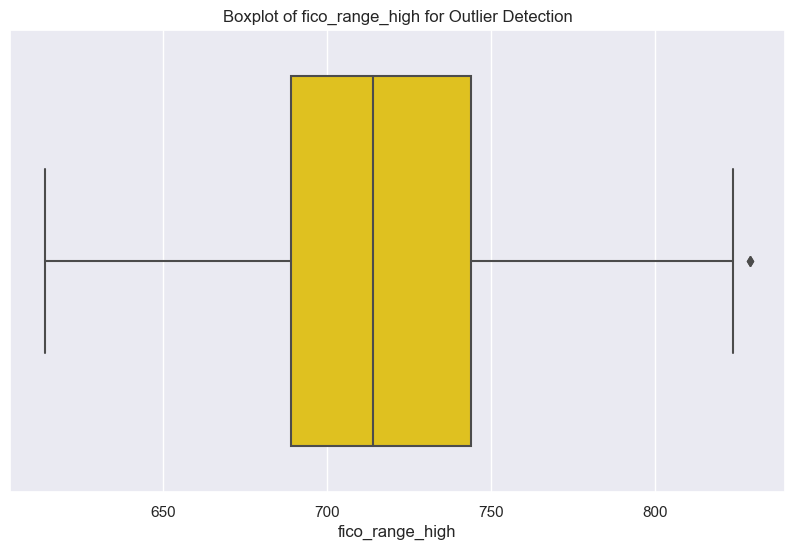

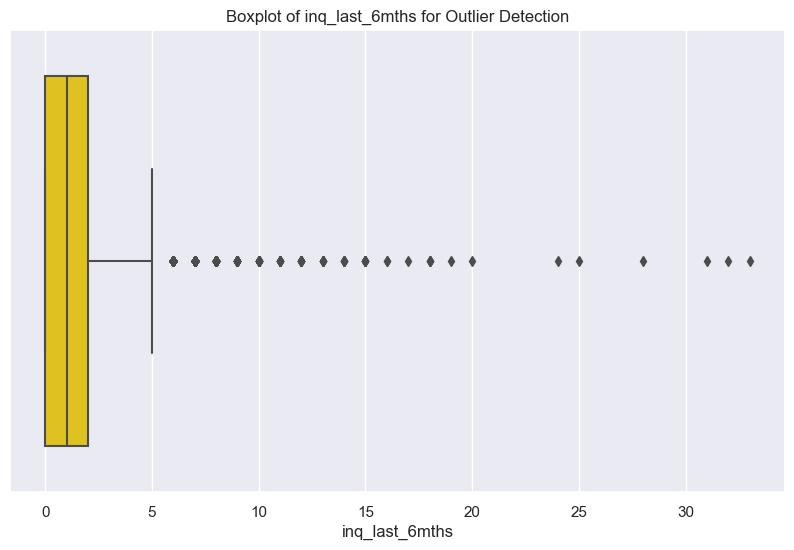

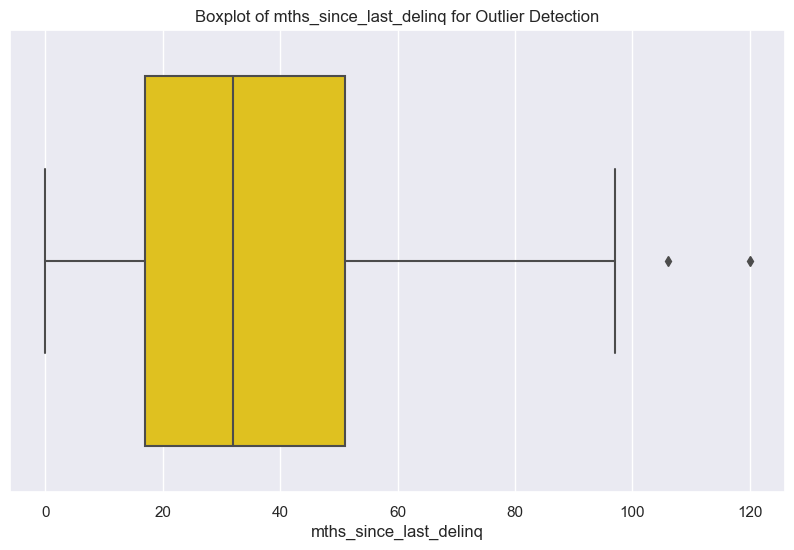

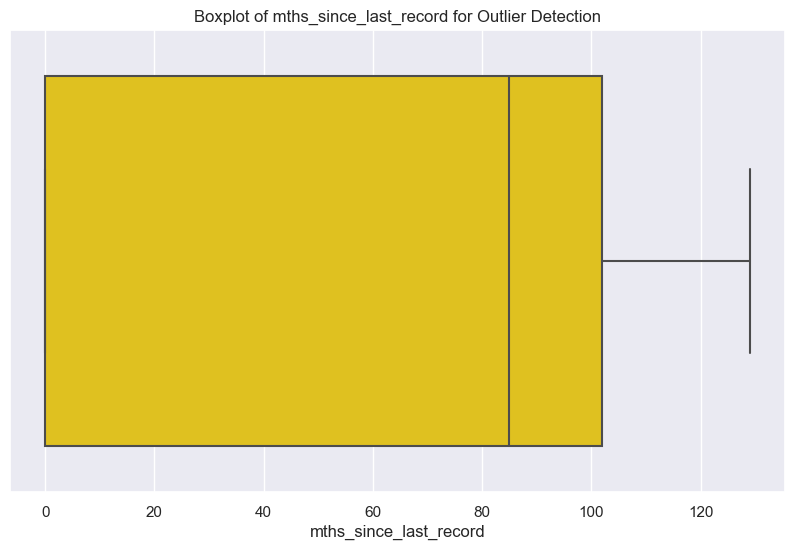

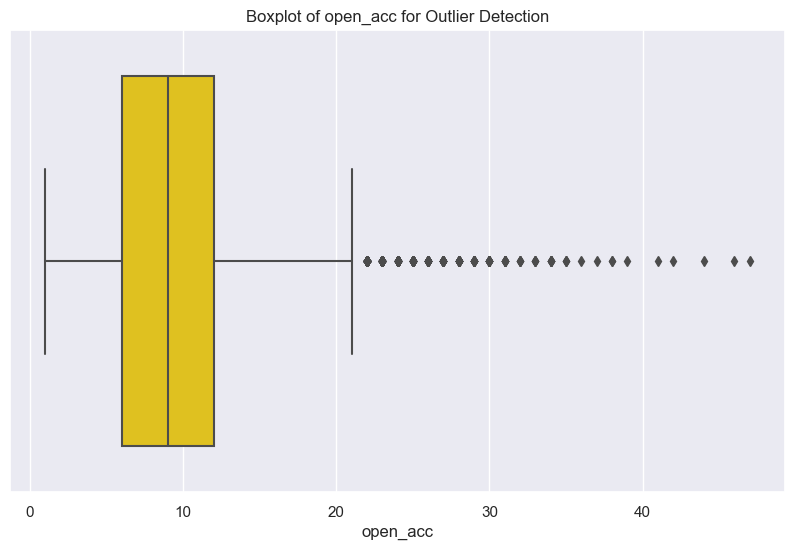

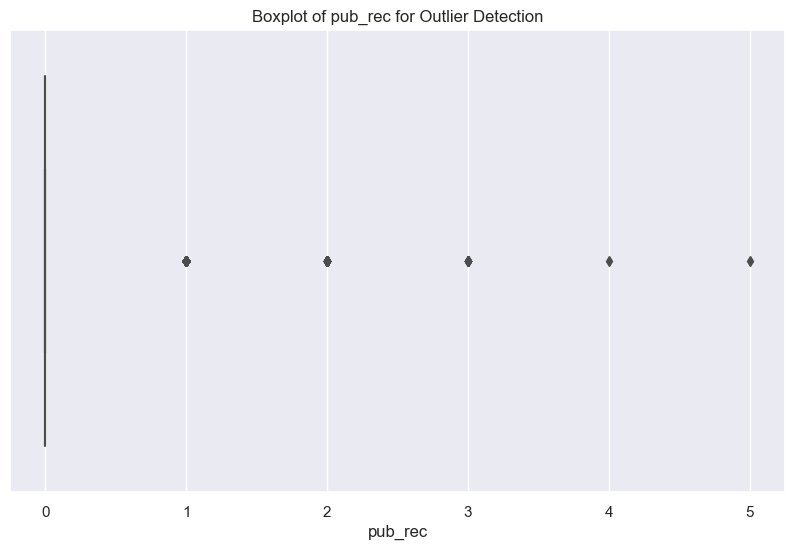

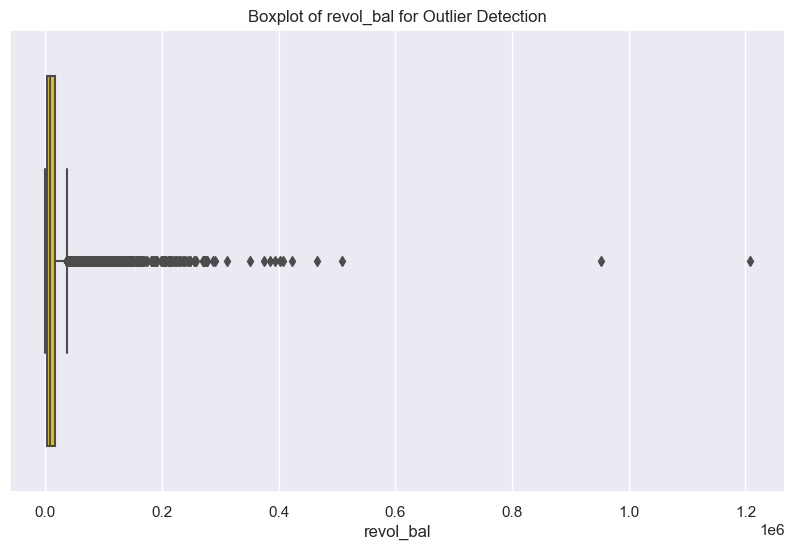

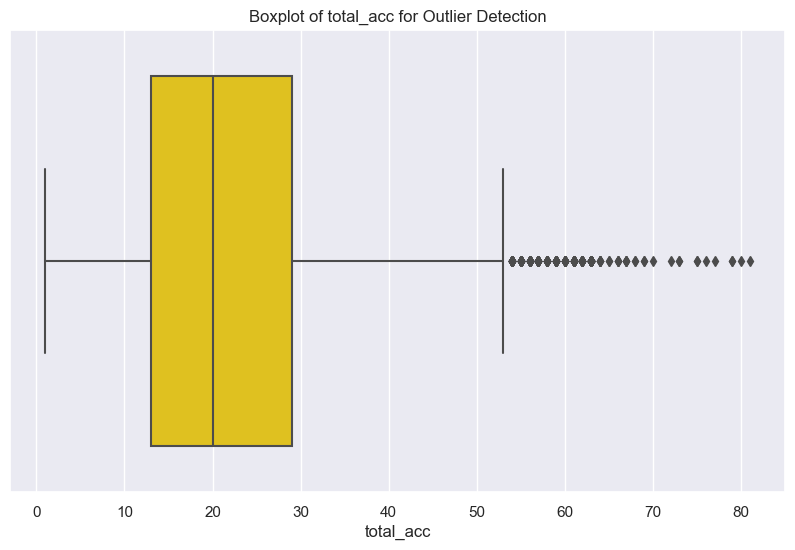

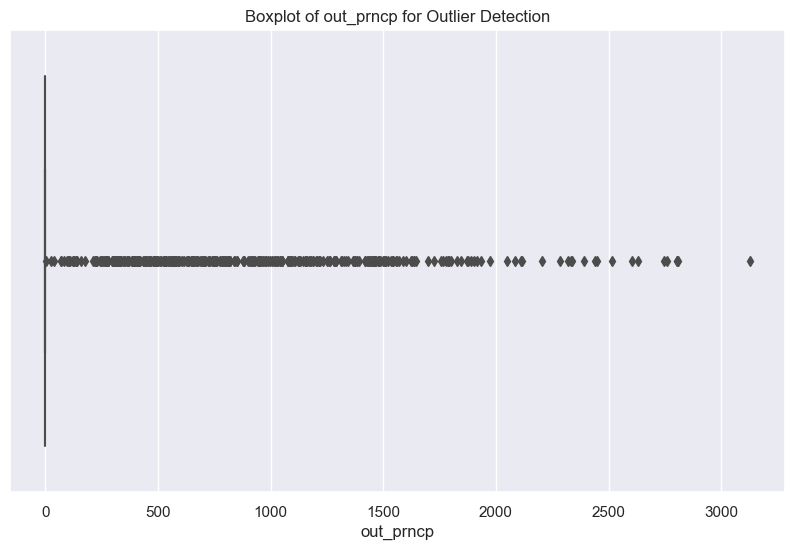

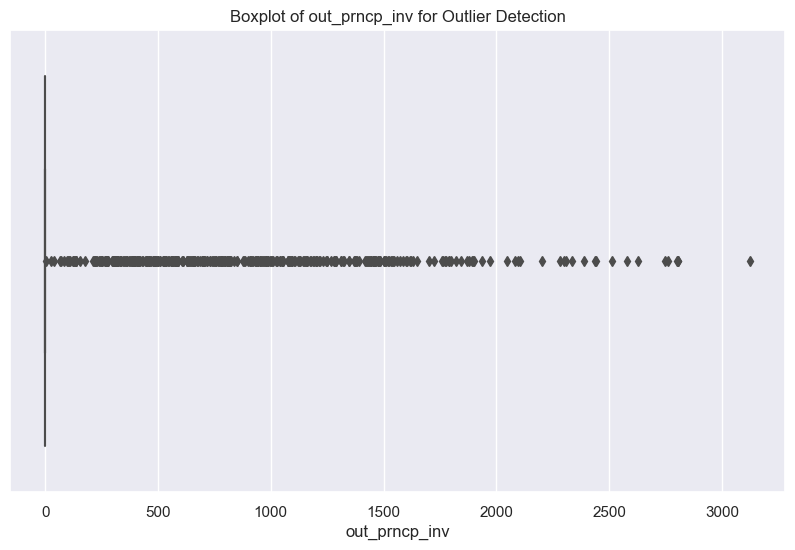

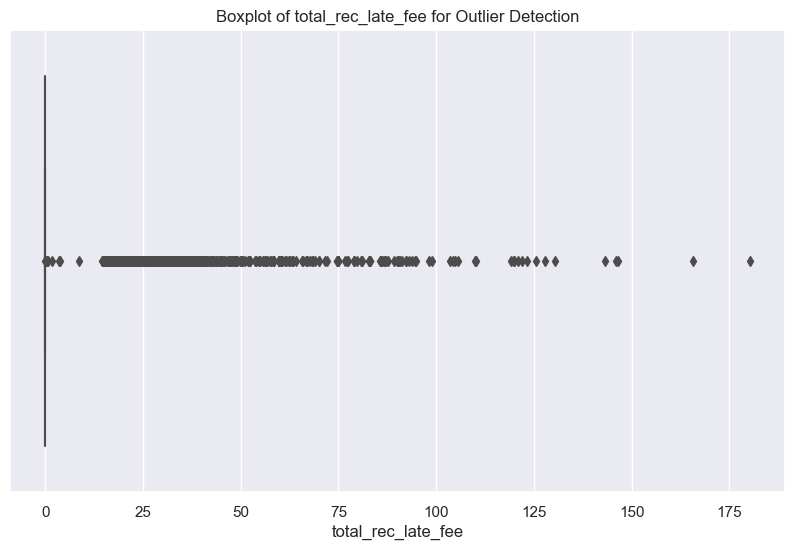

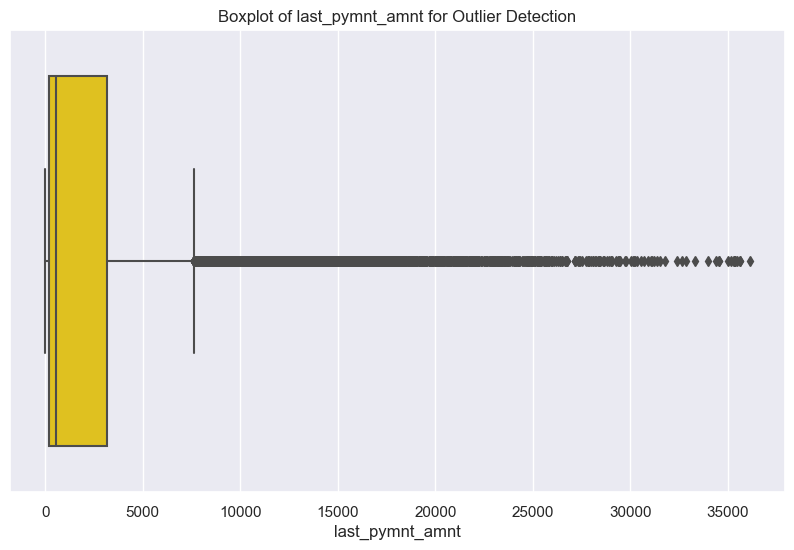

In [63]:
for num_feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=loan, x=num_feature, color='gold')
    plt.title(f'Boxplot of {num_feature} for Outlier Detection')
    plt.xlabel(num_feature)
    plt.show()


Identifying Potential Outliers: Boxplots for each numerical feature visually represent the distribution and help in identifying outliers.

### This is where the real stuff(copy and pasting) begins

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    loan[numerical_features + categorical_features],
    loan[target_var],
    test_size=0.2,
    random_state=42)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [65]:
def evaluate_model_performance(estimator, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Generate predictions for both train and test sets
    predictions_train = estimator.predict(X_train)
    probabilities_train = estimator.predict_proba(X_train)[:, 1]

    predictions_test = estimator.predict(X_test)
    probabilities_test = estimator.predict_proba(X_test)[:, 1]

    # Convert labels to a binary format for AUC calculation
    label_encoder = LabelBinarizer()
    y_train_encoded = label_encoder.fit_transform(y_train).flatten()
    y_test_encoded = label_encoder.transform(y_test).flatten()

    # Compute various performance metrics
    accuracy_train = accuracy_score(y_train, predictions_train)
    accuracy_test = accuracy_score(y_test, predictions_test)

    precision_train = precision_score(y_train, predictions_train)
    precision_test = precision_score(y_test, predictions_test)

    recall_train = recall_score(y_train, predictions_train)
    recall_test = recall_score(y_test, predictions_test)

    f1_train = f1_score(y_train, predictions_train)
    f1_test = f1_score(y_test, predictions_test)

    auc_train = roc_auc_score(y_train_encoded, probabilities_train)
    auc_test = roc_auc_score(y_test_encoded, probabilities_test)

    # Display the metrics
    print("Training Performance:")
    print(f"Accuracy: {accuracy_train:.2f}, Precision: {precision_train:.2f}, Recall: {recall_train:.2f}, F1-Score: {f1_train:.2f}, AUC: {auc_train:.2f}")
    
    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_test:.2f}, Precision: {precision_test:.2f}, Recall: {recall_test:.2f}, F1-Score: {f1_test:.2f}, AUC: {auc_test:.2f}")

    # Plotting ROC and Precision-Recall curves
    fpr_test, tpr_test, roc_thresholds = roc_curve(y_test_encoded, probabilities_test)
    roc_auc_val = auc(fpr_test, tpr_test)

    precisions, recalls, pr_thresholds = precision_recall_curve(y_test_encoded, probabilities_test)
    pr_auc_val = auc(recalls, precisions)

    plt.figure(figsize=(14, 7))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr_test, tpr_test, label=f'Area Under Curve (AUC) = {roc_auc_val:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    roc_selected_idx = np.argmin(np.abs(roc_thresholds - 0.5))
    plt.plot(fpr_test[roc_selected_idx], tpr_test[roc_selected_idx], 'ro')
    plt.annotate(f'Threshold={roc_thresholds[roc_selected_idx]:.2f}\nTPR={tpr_test[roc_selected_idx]:.2f}\nFPR={fpr_test[roc_selected_idx]:.2f}',
                 (fpr_test[roc_selected_idx], tpr_test[roc_selected_idx]),
                 textcoords="offset points",
                 xytext=(-10,10),
                 ha='center')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="best")

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recalls, precisions, label=f'PR Curve (AUC = {pr_auc_val:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    pr_selected_index = np.argmin(np.abs(pr_thresholds - roc_thresholds[roc_selected_idx]))
    plt.plot(recalls[pr_selected_index], precisions[pr_selected_index], 'ro')
    plt.annotate(f'Threshold={roc_thresholds[roc_selected_idx]:.2f}\nPrecision={precisions[pr_selected_index]:.2f}\nRecall={recalls[pr_selected_index]:.2f}',
                 (recalls[pr_selected_index], precisions[pr_selected_index]),
                 textcoords="offset points",
                 xytext=(-10,10),
                 ha='center')
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [66]:
feature_names = numerical_features + categorical_features


def calculate_permutation_importance(estimator, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, features=feature_names):
    perm_importance_result = permutation_importance(estimator, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

    sorted_indices = perm_importance_result.importances_mean.argsort()[::-1]
    for idx in sorted_indices:
        if perm_importance_result.importances_mean[idx] - 2 * perm_importance_result.importances_std[idx] > 0:
            print(f"Feature: {features[idx]}, Mean Importance: {perm_importance_result.importances_mean[idx]:.3f} +/- {perm_importance_result.importances_std[idx]:.3f}")

    importance_data_frame = pd.DataFrame({
        'Feature': features,
        'Importance Mean': perm_importance_result.importances_mean,
        'Importance Std': perm_importance_result.importances_std
    }).sort_values(by='Importance Mean', ascending=False).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_data_frame, x='Importance Mean', y='Feature')
    plt.title('Feature Importance via Permutation')
    plt.tight_layout()
    plt.show()

### Model 1 Logistic Regression 

In [67]:
logistic_regression_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('logistic_regression_model', LogisticRegression(random_state=0, max_iter=300))
])
logistic_regression_pipeline.fit(X_train, y_train)


Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'm...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('logistic_regression_model',
                 LogisticRegression(max_iter=300, random_state=0))])

Training Performance:
Accuracy: 0.87, Precision: 0.66, Recall: 0.29, F1-Score: 0.40, AUC: 0.87

Testing Performance:
Accuracy: 0.87, Precision: 0.61, Recall: 0.26, F1-Score: 0.36, AUC: 0.86


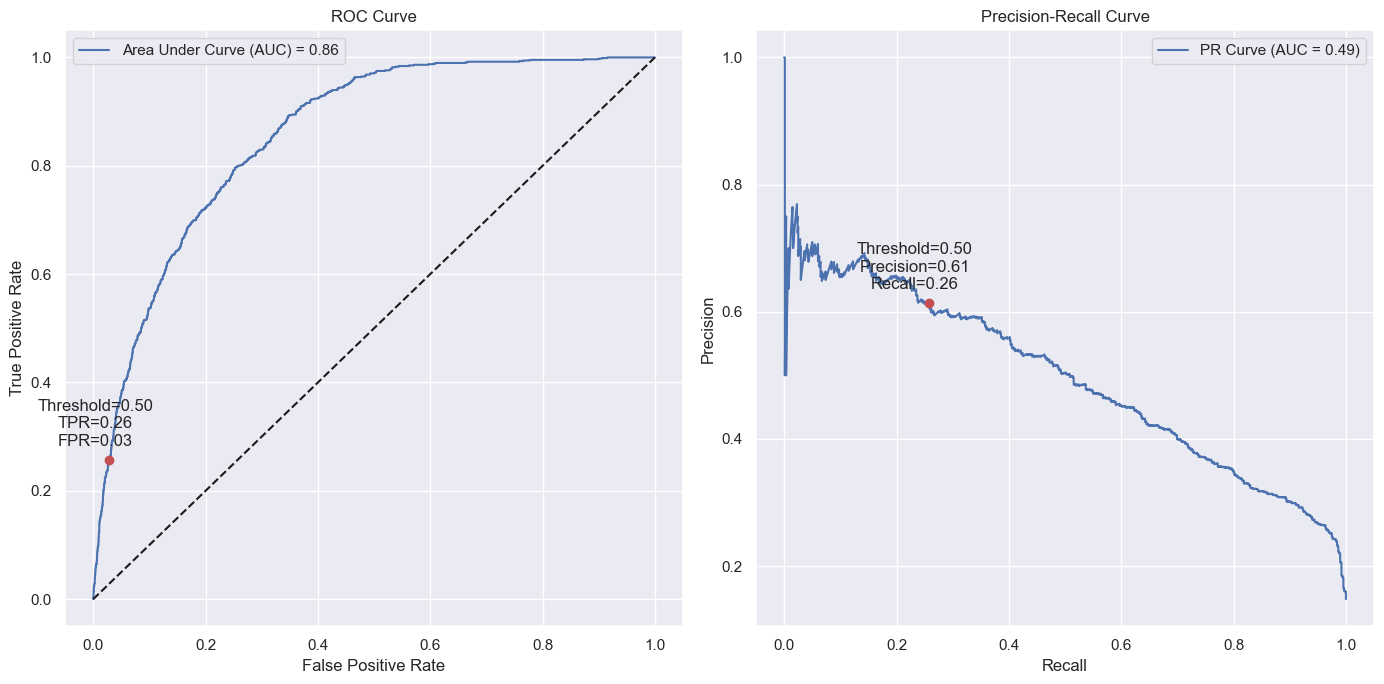

Feature: funded_amnt, Mean Importance: 0.063 +/- 0.003
Feature: int_rate, Mean Importance: 0.054 +/- 0.003
Feature: last_pymnt_amnt, Mean Importance: 0.046 +/- 0.003
Feature: funded_amnt_inv, Mean Importance: 0.017 +/- 0.002
Feature: grade, Mean Importance: 0.017 +/- 0.002
Feature: term, Mean Importance: 0.008 +/- 0.002
Feature: installment, Mean Importance: 0.003 +/- 0.001
Feature: total_rec_late_fee, Mean Importance: 0.001 +/- 0.000
Feature: out_prncp_inv, Mean Importance: 0.001 +/- 0.000
Feature: out_prncp, Mean Importance: 0.001 +/- 0.000
Feature: delinq_2yrs, Mean Importance: 0.001 +/- 0.000
Feature: mths_since_last_delinq, Mean Importance: 0.000 +/- 0.000


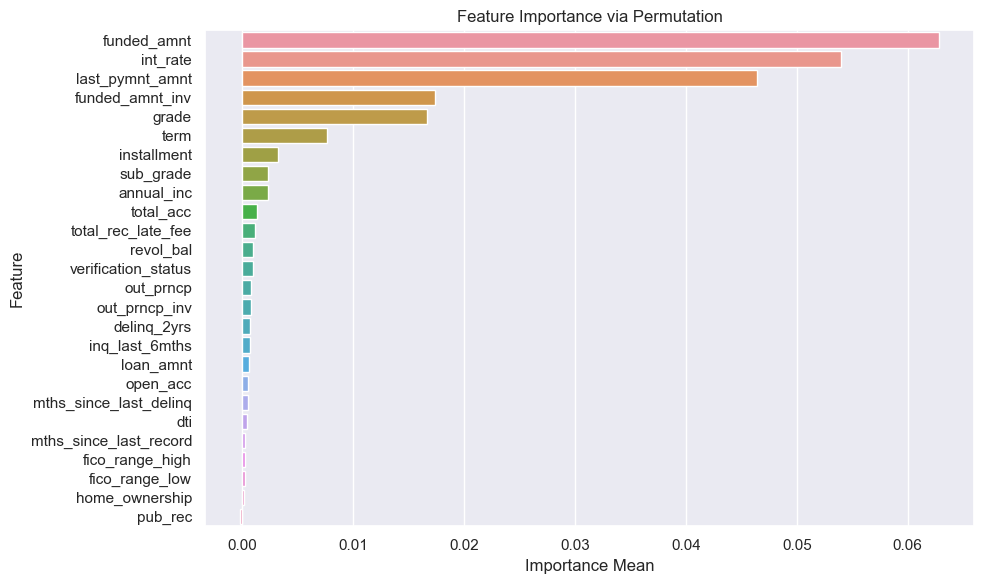

In [68]:
evaluate_model_performance(logistic_regression_pipeline)
calculate_permutation_importance(logistic_regression_pipeline)

### Model 2 Random Forest

Training Performance:
Accuracy: 0.85, Precision: 0.93, Recall: 0.03, F1-Score: 0.06, AUC: 0.79

Testing Performance:
Accuracy: 0.85, Precision: 0.75, Recall: 0.02, F1-Score: 0.03, AUC: 0.77


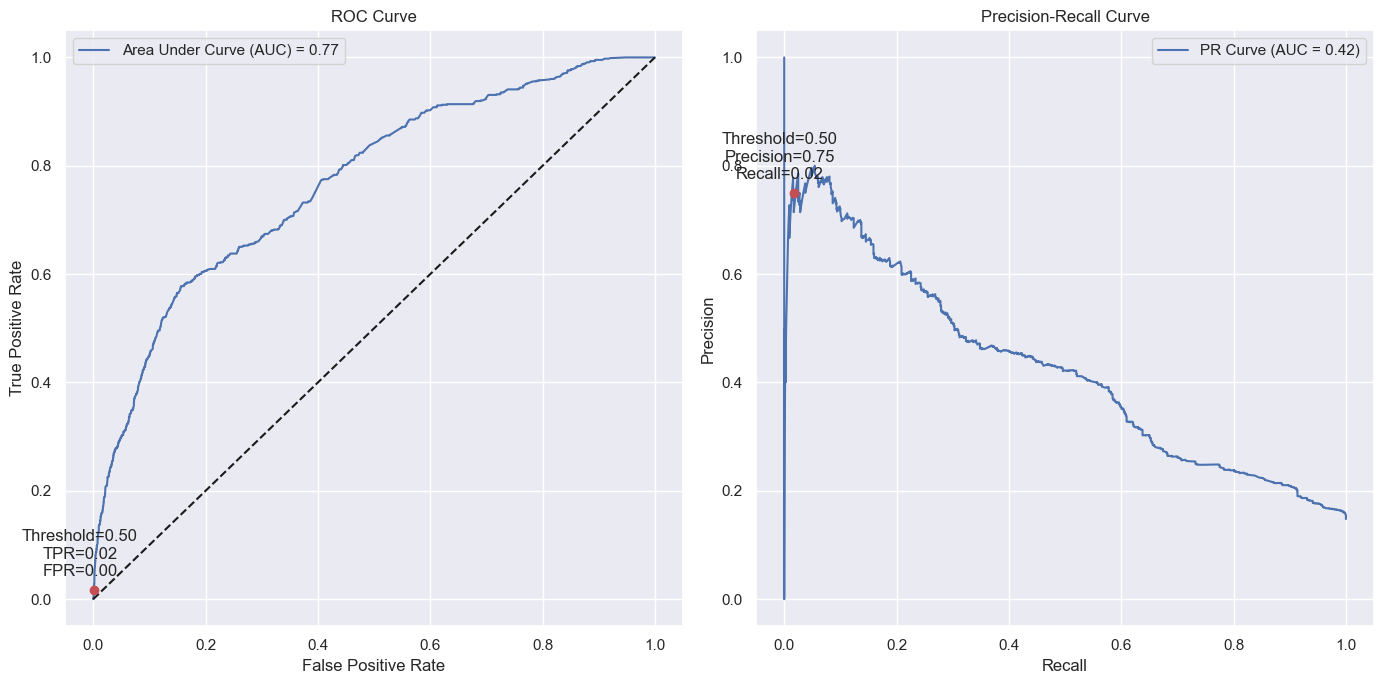

In [69]:
random_forest_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('random_forest_model', RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0, max_depth=5))
])
random_forest_pipeline.fit(X_train, y_train)

evaluate_model_performance(random_forest_pipeline)

In [70]:
random_forest_params = {
    'random_forest_model__n_estimators': [20, 30, 50],
    'random_forest_model__max_depth': [None, 5, 10],
    'random_forest_model__min_samples_split': [5, 10],
    'random_forest_model__min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(random_forest_pipeline, random_forest_params, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_rf.fit(X_train, y_train)

best_hyperparams = grid_search_rf.best_params_
print("Optimal Hyperparameters:")
for param, val in best_hyperparams.items():
    print(f"  {param}: {val}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Optimal Hyperparameters:
  random_forest_model__max_depth: None
  random_forest_model__min_samples_leaf: 4
  random_forest_model__min_samples_split: 5
  random_forest_model__n_estimators: 50


Re-training Random Forest Pipeline with Best Hyperparameters

Training Performance:
Accuracy: 0.92, Precision: 0.98, Recall: 0.50, F1-Score: 0.66, AUC: 0.99

Testing Performance:
Accuracy: 0.87, Precision: 0.68, Recall: 0.20, F1-Score: 0.30, AUC: 0.87


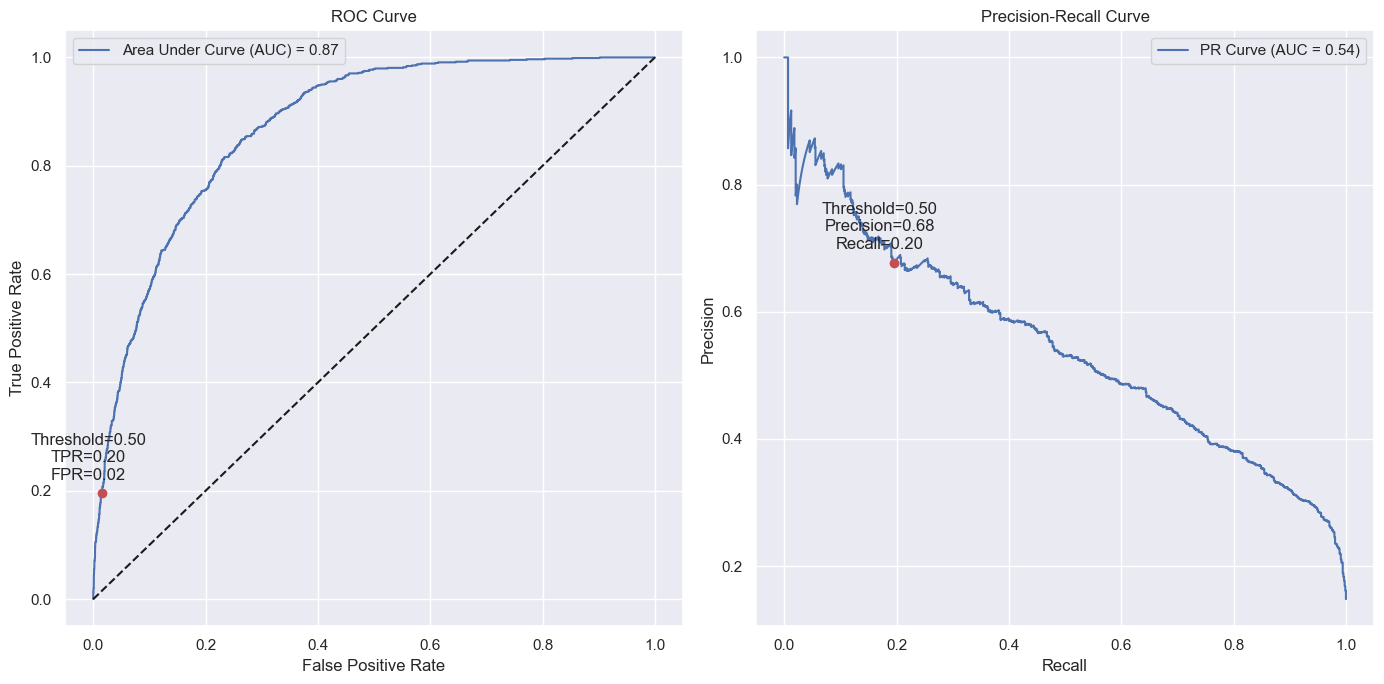

Feature: last_pymnt_amnt, Mean Importance: 0.029 +/- 0.002
Feature: term, Mean Importance: 0.007 +/- 0.001
Feature: total_rec_late_fee, Mean Importance: 0.007 +/- 0.001
Feature: int_rate, Mean Importance: 0.003 +/- 0.001


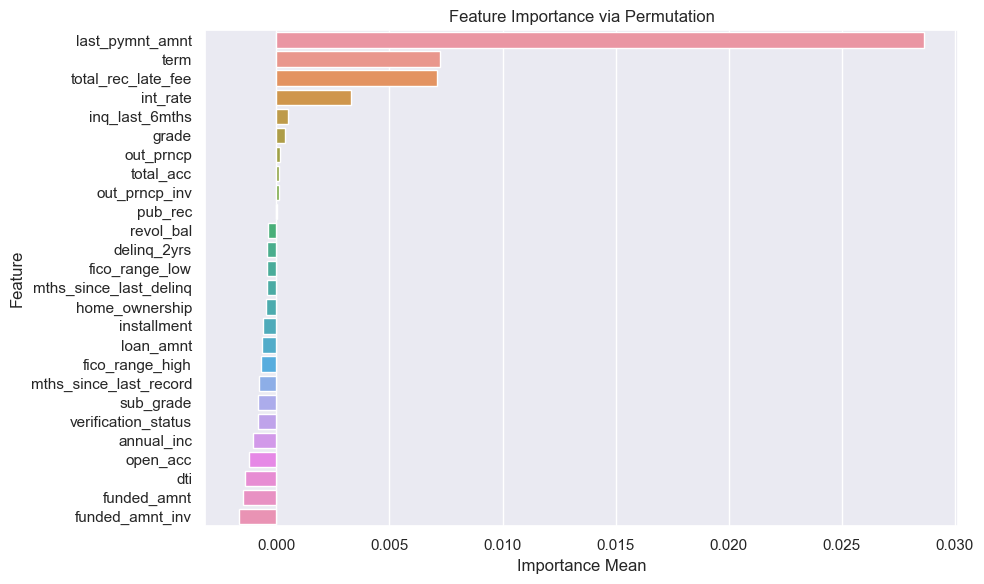

In [71]:
optimized_rf_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('random_forest_model', RandomForestClassifier(n_estimators=50, random_state=0, min_samples_leaf=4, min_samples_split=10))
])
optimized_rf_pipeline.fit(X_train, y_train)

evaluate_model_performance(optimized_rf_pipeline)
calculate_permutation_importance(optimized_rf_pipeline)

### Model 3 GBM

In [72]:
gradient_boosting_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('gbm_model', GradientBoostingClassifier(n_estimators=20, random_state=0))
])
gradient_boosting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'm...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('gbm_model',
                 GradientBoostingClassifier(n_estimators=20, random_state=0))])

Training Performance:
Accuracy: 0.87, Precision: 0.80, Recall: 0.16, F1-Score: 0.27, AUC: 0.88

Testing Performance:
Accuracy: 0.87, Precision: 0.77, Recall: 0.12, F1-Score: 0.21, AUC: 0.87


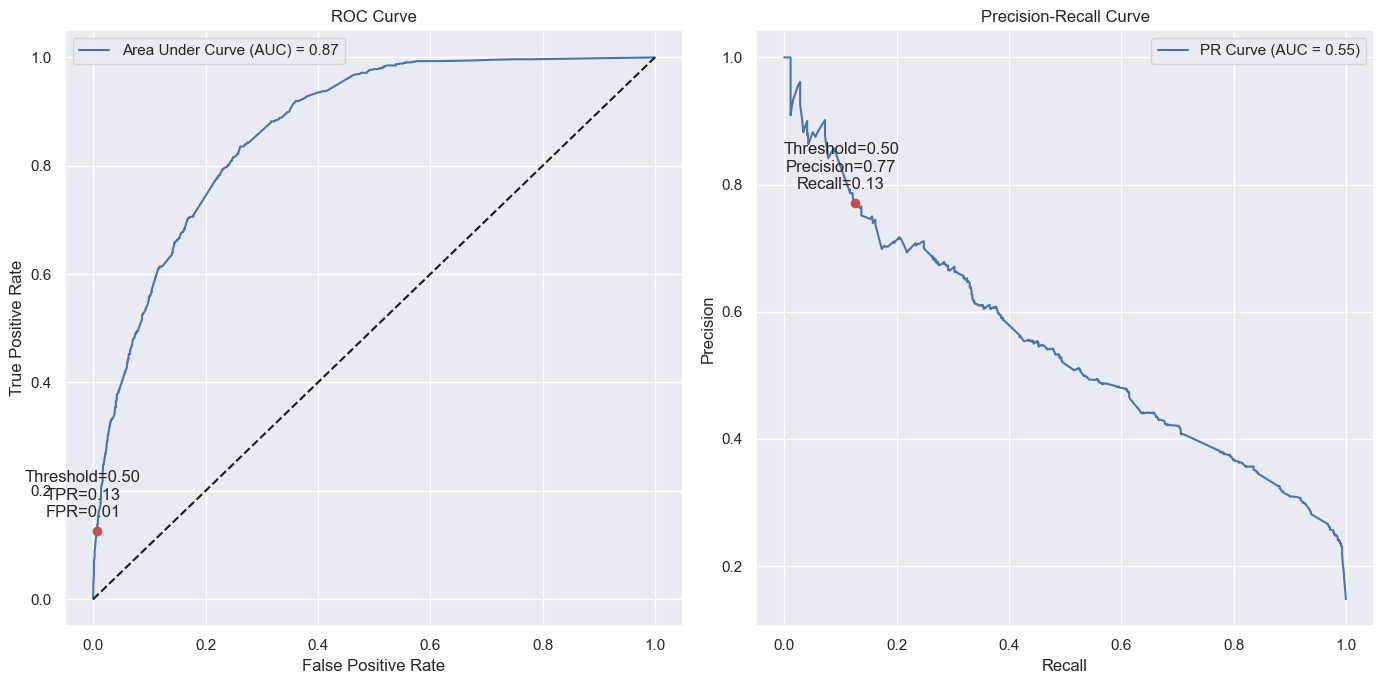

In [73]:
evaluate_model_performance(gradient_boosting_pipeline)

In [74]:
gbm_param_grid = {
    'gbm_model__n_estimators': [100, 200],
    'gbm_model__learning_rate': [0.05, 0.1, 0.2],
}

grid_search_gbm = GridSearchCV(gradient_boosting_pipeline, gbm_param_grid, cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_gbm.fit(X_train, y_train)

best_gbm_params = grid_search_gbm.best_params_
print("Optimal parameters found:")
for param, val in best_gbm_params.items():
    print(f"  {param}: {val}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Optimal parameters found:
  gbm_model__learning_rate: 0.2
  gbm_model__n_estimators: 200


In [75]:
optimized_gbm_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('gbm_model', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=0))
])
optimized_gbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'm...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('gbm_model',
                 GradientBoostingClassifier(learning_rate=0.2, n_estimators=200,
                                            random_state=0))])

Training Performance:
Accuracy: 0.91, Precision: 0.81, Recall: 0.51, F1-Score: 0.63, AUC: 0.94

Testing Performance:
Accuracy: 0.88, Precision: 0.68, Recall: 0.39, F1-Score: 0.50, AUC: 0.90


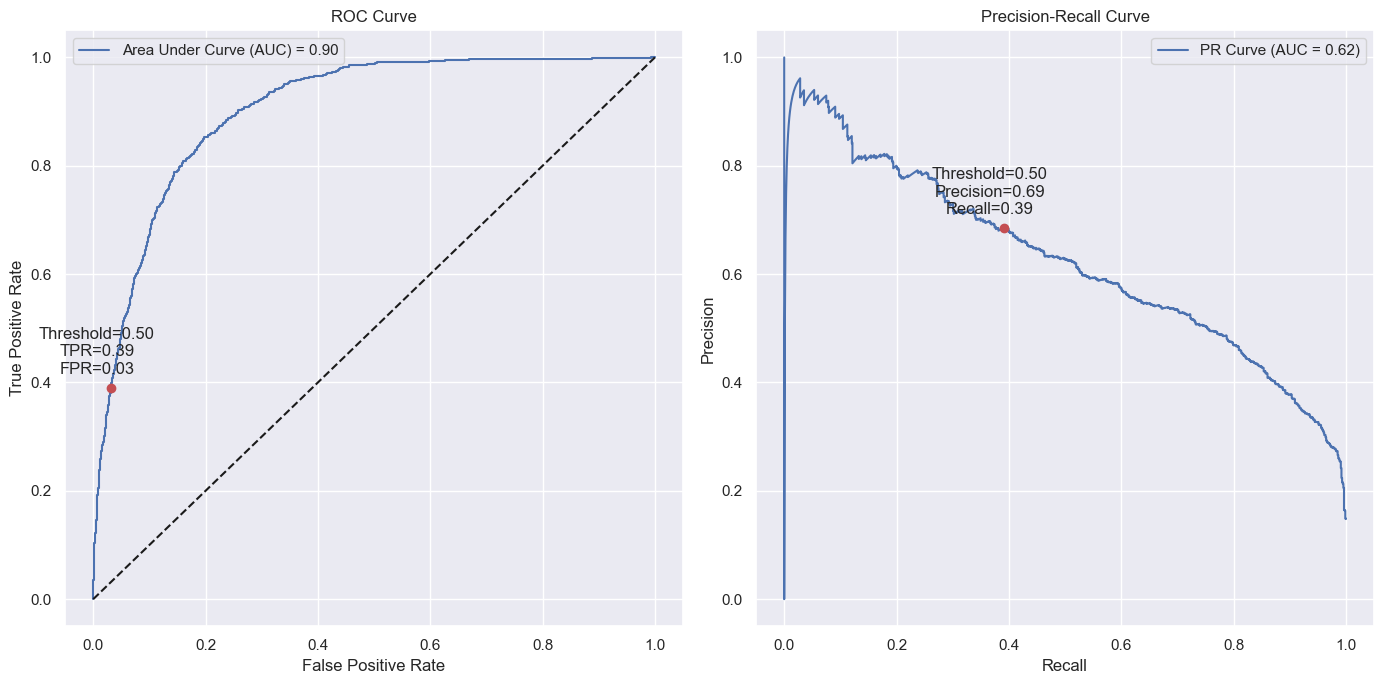

Feature: last_pymnt_amnt, Mean Importance: 0.068 +/- 0.004
Feature: installment, Mean Importance: 0.021 +/- 0.001
Feature: total_rec_late_fee, Mean Importance: 0.014 +/- 0.001
Feature: int_rate, Mean Importance: 0.013 +/- 0.002
Feature: annual_inc, Mean Importance: 0.006 +/- 0.002
Feature: term, Mean Importance: 0.006 +/- 0.001
Feature: funded_amnt_inv, Mean Importance: 0.004 +/- 0.001
Feature: funded_amnt, Mean Importance: 0.004 +/- 0.001
Feature: inq_last_6mths, Mean Importance: 0.003 +/- 0.001
Feature: out_prncp, Mean Importance: 0.002 +/- 0.000
Feature: out_prncp_inv, Mean Importance: 0.001 +/- 0.000


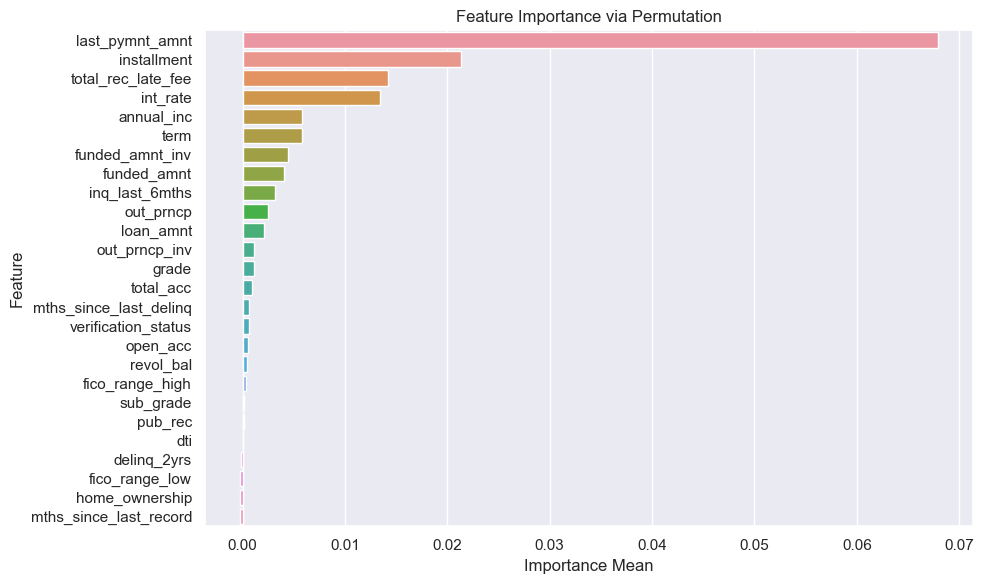

In [76]:
evaluate_model_performance(optimized_gbm_pipeline)
calculate_permutation_importance(optimized_gbm_pipeline)

### Model 4 Neural Network

In [77]:
neural_network_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('nn_classifier', MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam', max_iter=500, random_state=42))
])
neural_network_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'm...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('nn_classifier',
                 MLPClassifier(hidden_layer_sizes=(20,), max_iter=500,
                               random_state=42))])

Training Performance:
Accuracy: 0.88, Precision: 0.67, Recall: 0.46, F1-Score: 0.55, AUC: 0.91

Testing Performance:
Accuracy: 0.86, Precision: 0.56, Recall: 0.37, F1-Score: 0.45, AUC: 0.86


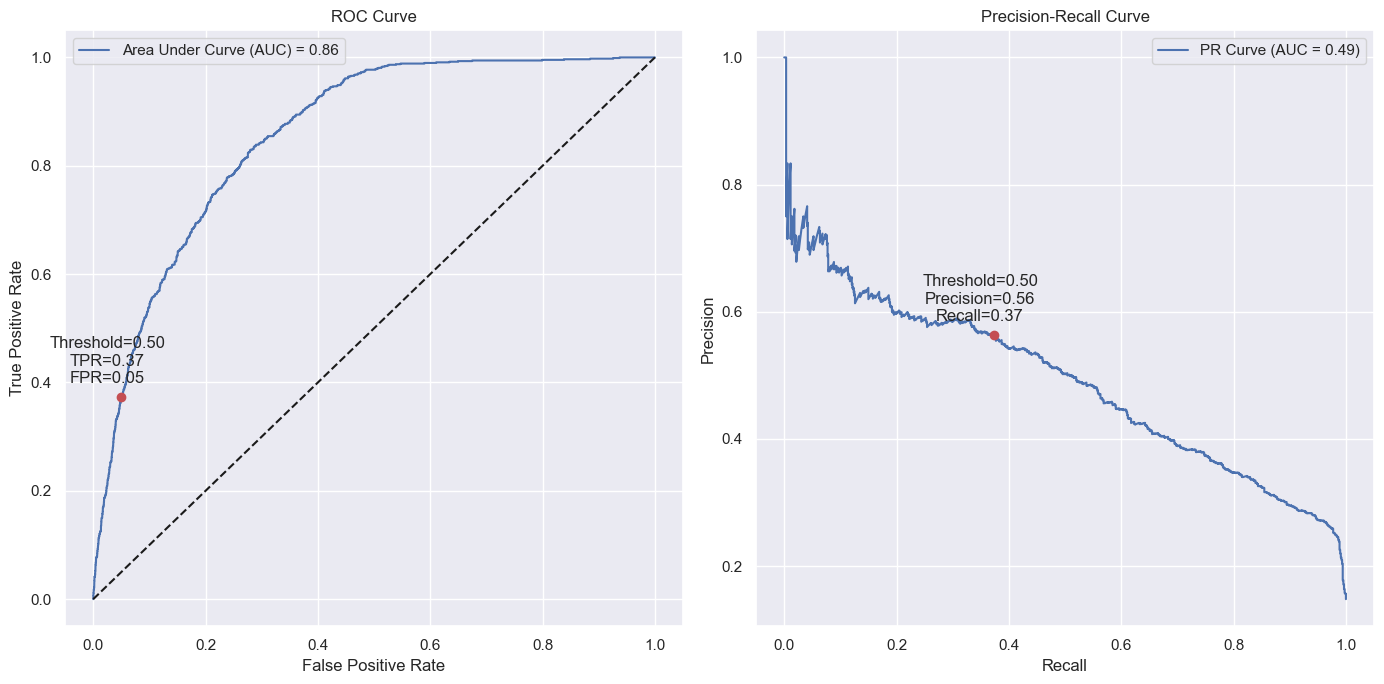

In [78]:
evaluate_model_performance(neural_network_pipeline)

In [79]:
nn_param_grid = {
    'nn_classifier__hidden_layer_sizes': [(50,), (100,)],
    'nn_classifier__alpha': [0.0001, 0.001],
    'nn_classifier__learning_rate_init': [0.001, 0.01],
}

grid_search_nn = GridSearchCV(neural_network_pipeline, nn_param_grid, cv=2, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_nn.fit(X_train, y_train)

optimal_nn_params = grid_search_nn.best_params_
print("Optimal parameters discovered:")
for param, val in optimal_nn_params.items():
    print(f"  {param}: {val}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

Optimal parameters discovered:
  nn_classifier__alpha: 0.001
  nn_classifier__hidden_layer_sizes: (50,)
  nn_classifier__learning_rate_init: 0.001


In [80]:
optimized_nn_pipeline = Pipeline([
    ('data_preprocessing', preprocessor),
    ('nn_classifier', MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=42, learning_rate_init=0.001, alpha=0.0001))
])
optimized_nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'm...
                                                   'out_prncp', 'out_prncp_inv',
                                                   'total_rec_late_fee',
                                                   'last_pymnt_amnt']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['term', 'grade', 'sub_grade',
                                                   'home_ownership',
                                                   'verification_status'])])),
                ('nn_classifier',
                 MLPClassifier(hidden_layer_sizes=(50,), max_iter=500,
                               random_state=42))])

Training Performance:
Accuracy: 0.91, Precision: 0.78, Recall: 0.55, F1-Score: 0.65, AUC: 0.94

Testing Performance:
Accuracy: 0.85, Precision: 0.49, Recall: 0.34, F1-Score: 0.40, AUC: 0.84


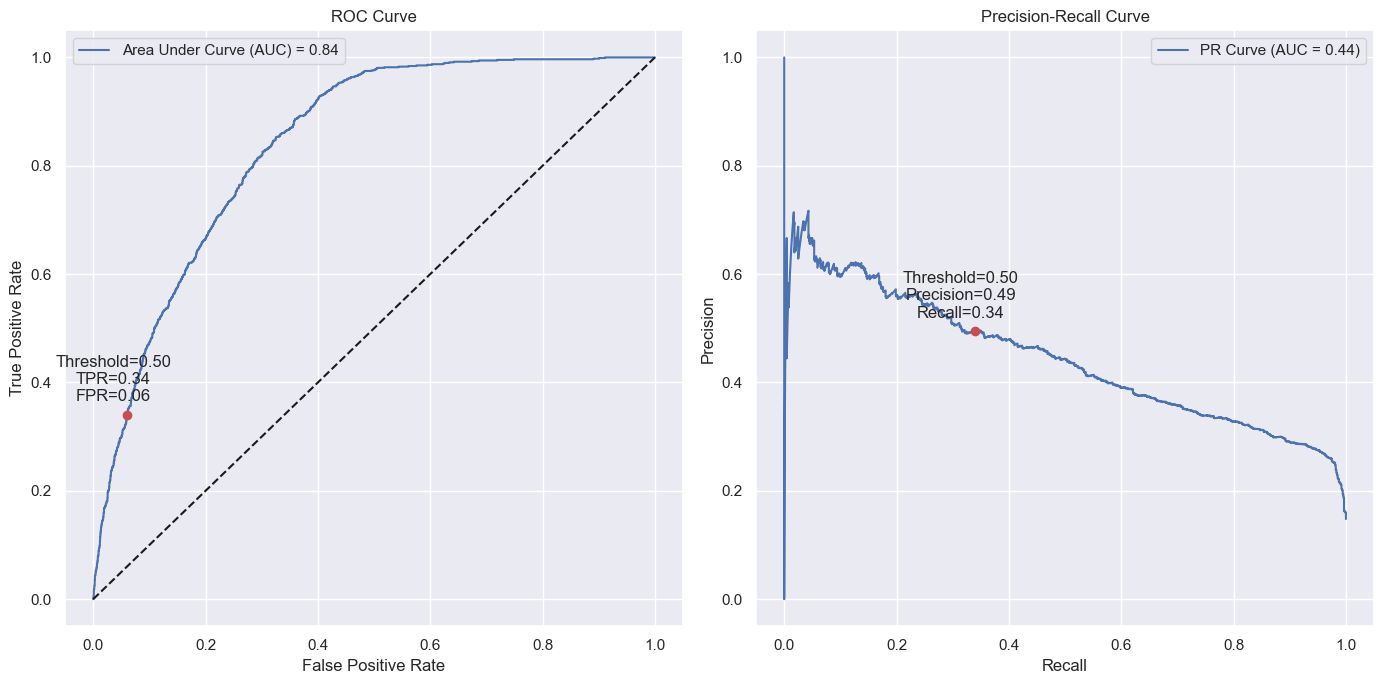

Feature: last_pymnt_amnt, Mean Importance: 0.051 +/- 0.002
Feature: int_rate, Mean Importance: 0.044 +/- 0.003
Feature: funded_amnt, Mean Importance: 0.026 +/- 0.003
Feature: grade, Mean Importance: 0.022 +/- 0.003
Feature: term, Mean Importance: 0.016 +/- 0.002
Feature: funded_amnt_inv, Mean Importance: 0.015 +/- 0.002
Feature: sub_grade, Mean Importance: 0.011 +/- 0.002
Feature: installment, Mean Importance: 0.008 +/- 0.002
Feature: annual_inc, Mean Importance: 0.006 +/- 0.002
Feature: home_ownership, Mean Importance: 0.005 +/- 0.001
Feature: out_prncp, Mean Importance: 0.001 +/- 0.000


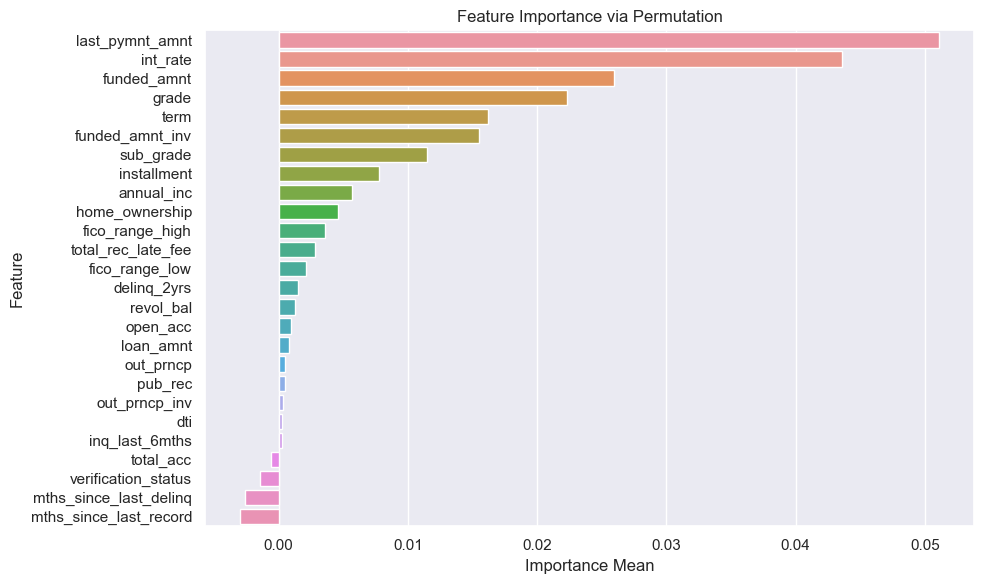

In [81]:
evaluate_model_performance(optimized_nn_pipeline)
calculate_permutation_importance(optimized_nn_pipeline)

### Model 5 Stacking Classifier

In [82]:
stacking_pipeline = Pipeline([
    ('data_preprocessor', preprocessor),
    ('ensemble_model', StackingClassifier(
        estimators=[
            ('gradient_boosting', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=0)),
            ('random_forest', RandomForestClassifier(n_estimators=50, random_state=0, min_samples_leaf=4, min_samples_split=10)),
            ('neural_network', MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=42, learning_rate_init=0.001, alpha=0.0001))
        ],
        final_estimator=LogisticRegression(),
        cv=3,
        n_jobs=-1
    ))
])

stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'funded_amnt',
                                                   'funded_amnt_inv',
                                                   'int_rate', 'installment',
                                                   'annual_inc', 'dti',
                                                   'delinq_2yrs',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'inq_last_6mths',
                                                   'mths_since_last_delinq',
                                                   'mt...
                                    estimators=[('gradient_boosting',
                                                 GradientBoostingClassifier(learning_rate=0.2,
                                                                            n_estimators=200,
                                                                            random_state=0)),
                                                ('random_forest',
                                                 RandomForestClassifier(min_samples_leaf=4,
                                                                        min_samples_split=10,
                                                                        n_estimators=50,
                                                                        random_state=0)),
                                                ('neural_network',
                                                 MLPClassifier(hidden_layer_sizes=(50,),
                                                               max_iter=500,
                                                               random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

Training Performance:
Accuracy: 0.92, Precision: 0.84, Recall: 0.58, F1-Score: 0.69, AUC: 0.96

Testing Performance:
Accuracy: 0.88, Precision: 0.66, Recall: 0.41, F1-Score: 0.50, AUC: 0.90


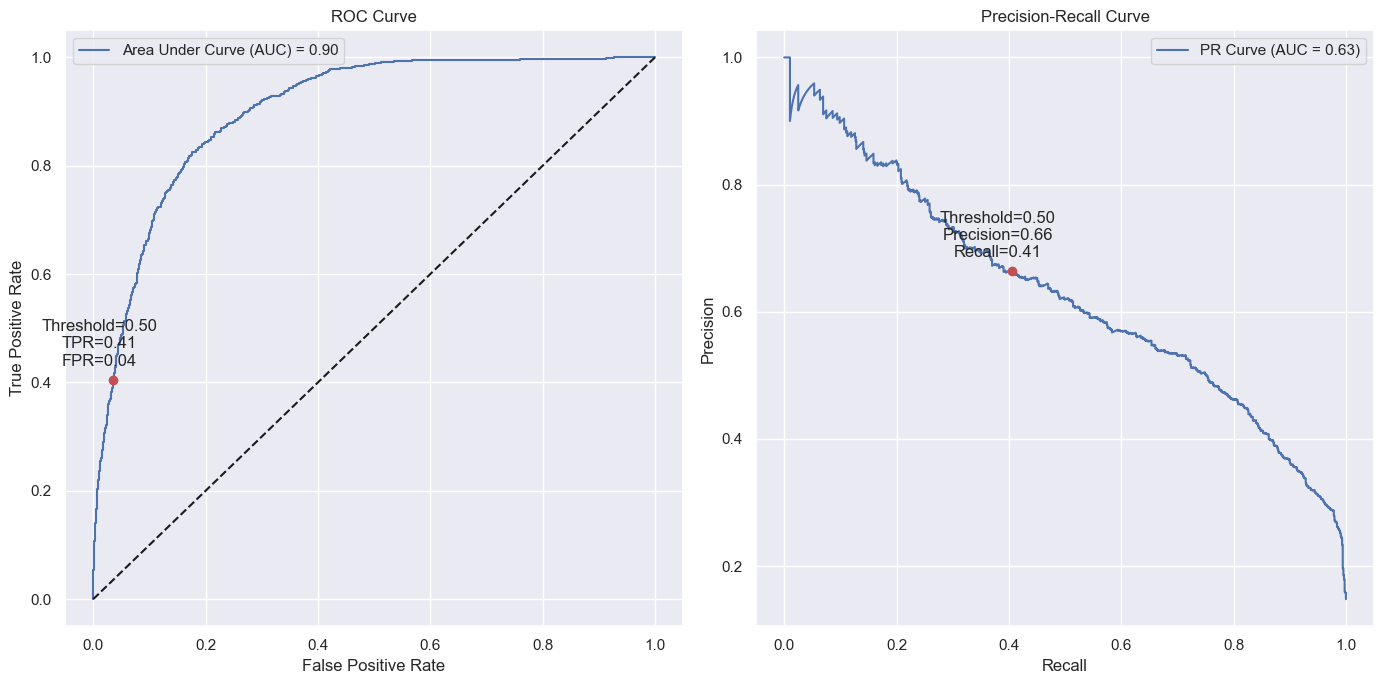

Feature: last_pymnt_amnt, Mean Importance: 0.070 +/- 0.003
Feature: installment, Mean Importance: 0.016 +/- 0.001
Feature: total_rec_late_fee, Mean Importance: 0.014 +/- 0.001
Feature: int_rate, Mean Importance: 0.011 +/- 0.002
Feature: annual_inc, Mean Importance: 0.006 +/- 0.002
Feature: term, Mean Importance: 0.006 +/- 0.001
Feature: funded_amnt_inv, Mean Importance: 0.004 +/- 0.001
Feature: out_prncp, Mean Importance: 0.003 +/- 0.000
Feature: inq_last_6mths, Mean Importance: 0.002 +/- 0.001
Feature: out_prncp_inv, Mean Importance: 0.001 +/- 0.000


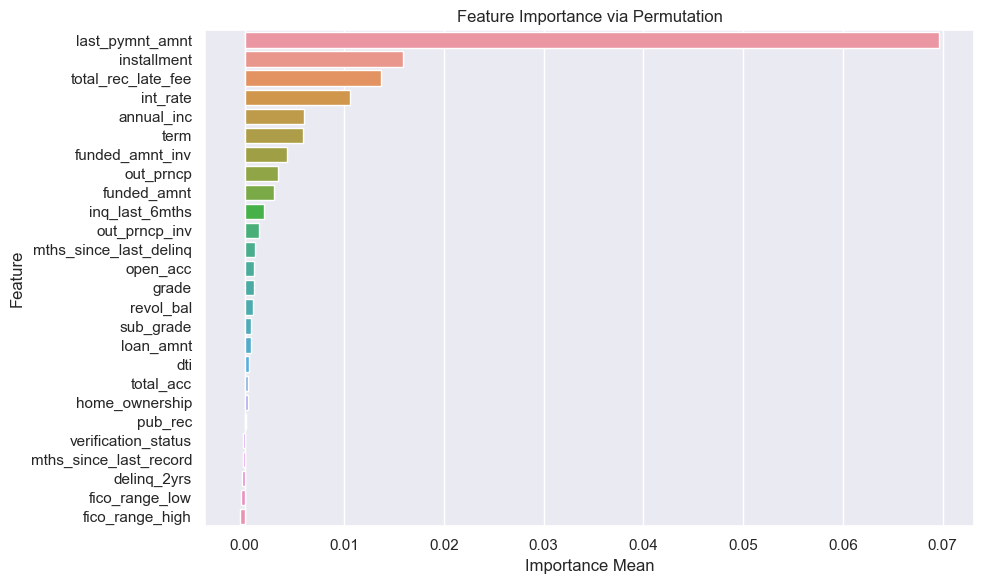

In [83]:
evaluate_model_performance(stacking_pipeline)

calculate_permutation_importance(stacking_pipeline)

In [84]:
# Initialize an explainer for the stacked classifier pipeline
stacked_model_explainer = dalex.Explainer(stacking_pipeline, X_test, y_test)
stacked_model_explainer

Preparation of a new explainer is initiated

  -> data              : 5956 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5956 values
  -> model_class       : sklearn.ensemble._stacking.StackingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x162248b80> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0307, mean = 0.148, max = 0.972
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.964, mean = -0.000169, max = 0.968
  -> model_info        : package sklearn

A new explainer has been created!


In [85]:
# Evaluate the performance of the stacked classifier model
stacked_model_performance = stacked_model_explainer.model_performance(model_type='classification')
stacked_model_performance.result

recall  precision        f1  accuracy       auc
StackingClassifier  0.406356   0.664193  0.504225    0.8818  0.901516

### Best Model

Based on AUC, accuracy, precision, recall, and F1-score. The Stacking Classifier shows high AUC and balanced performance metrics, suggesting strong overall performance. So we generate partial dependence plots for it.

In [86]:
pip install nbformat --upgrade


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [87]:
# Calculate the feature importance using the explainer
feature_importance = stacked_model_explainer.model_parts(n_jobs=4)

# Visualize the feature importance
feature_importance.plot()

In [88]:
# Create PDPs for numeric features to understand their impact
pdp_for_numeric_features = stacked_model_explainer.model_profile(variables=numerical_features)

# Plot the PDPs for numeric features
pdp_for_numeric_features.plot()

Calculating ceteris paribus: 100%|██████████| 21/21 [00:03<00:00,  6.02it/s]


In [89]:
# Create PDPs for categorical features to analyze their influence
pdp_for_categorical_features = stacked_model_explainer.model_profile(
    variable_type='categorical',
    variables=categorical_features
)

# Visualize the PDPs for categorical features
pdp_for_categorical_features.plot()

Calculating ceteris paribus: 100%|██████████| 5/5 [00:00<00:00, 32.02it/s]


## Operational Strategy at 2% FPR & at 5% FPR

In [90]:
y_probs = stacking_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

In [92]:
desired_fpr = 0.02  # 2% false positive rate
closest_index_2 = np.argmin(np.abs(fpr - desired_fpr))
threshold_2_percent = thresholds[closest_index_2]

In [93]:
desired_fpr = 0.05  # 5% false positive rate
closest_index_5 = np.argmin(np.abs(fpr - desired_fpr))
threshold_5_percent = thresholds[closest_index_5]

In [94]:
predictions_at_2_percent_fpr = (y_probs >= threshold_2_percent).astype(int)
predictions_at_5_percent_fpr = (y_probs >= threshold_5_percent).astype(int)

In [95]:
precision_2_percent = precision_score(y_test, predictions_at_2_percent_fpr)
recall_2_percent = recall_score(y_test, predictions_at_2_percent_fpr)

precision_5_percent = precision_score(y_test, predictions_at_5_percent_fpr)
recall_5_percent = recall_score(y_test, predictions_at_5_percent_fpr)

print(f"2% FPR - Precision: {precision_2_percent:.2f}, Recall: {recall_2_percent:.2f}")
print(f"5% FPR - Precision: {precision_5_percent:.2f}, Recall: {recall_5_percent:.2f}")

2% FPR - Precision: 0.72, Recall: 0.30
5% FPR - Precision: 0.63, Recall: 0.49


### TOP 10 True Positives 
### TOP 10 False Positives
### TOP 10 False Negatives

In [97]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probabilities': y_probs})

true_positives = results_df[(results_df['Actual'] == 1) & (results_df['Predicted'] == 1)]
false_positives = results_df[(results_df['Actual'] == 0) & (results_df['Predicted'] == 1)]
false_negatives = results_df[(results_df['Actual'] == 1) & (results_df['Predicted'] == 0)]

top10_true_positives = true_positives.nlargest(10, 'Probabilities')
top10_false_positives = false_positives.nlargest(10, 'Probabilities')
top10_false_negatives = false_negatives.nsmallest(10, 'Probabilities')

top10_true_positives, top10_false_positives, top10_false_negatives

(       Actual  Predicted  Probabilities
 12578       1          1       0.971794
 22353       1          1       0.971033
 28908       1          1       0.970700
 8482        1          1       0.968549
 18662       1          1       0.968186
 13583       1          1       0.965679
 20838       1          1       0.964481
 6422        1          1       0.964406
 17217       1          1       0.963782
 2585        1          1       0.962671,
        Actual  Predicted  Probabilities
 10836       0          1       0.963647
 29509       0          1       0.956942
 17933       0          1       0.948299
 5210        0          1       0.944637
 10427       0          1       0.941579
 2320        0          1       0.941293
 6944        0          1       0.937249
 12776       0          1       0.931722
 10290       0          1       0.924902
 5453        0          1       0.921046,
        Actual  Predicted  Probabilities
 5393        1          0       0.031561
 18926       1

### Applying on holdout data

In [ ]:
def convert_percentage_to_float(df, column_name):
    df[column_name] = df[column_name].str.replace('%', '').astype(float) / 100

holdout_data = pd.read_csv("loan_holdout.csv")
convert_percentage_to_float(holdout_data, 'int_rate')

holdout_predictions = stacking_pipeline.predict_proba(holdout_data)[:, 1]

submission = pd.DataFrame({
    'id': holdout_data['id'],
    'prediction': holdout_predictions
})

submission.to_csv("loan_holdout_final.csv", index=False)